## Example 1 - Common Driver

Here we investigate the statistical association between summer precipitation (JJA mean) in Denmark (DK) and the Mediterranean (MED). A standard correlation test shows them to be negatively correlated (r = -0.24). However, this association is not causal but is due to both regions being affected by the position of the North Atlantic storm tracks, as described by the North Atlantic Oscillation (NAO) index.


### References / Notes

1. Mediterranean region as described in http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.368.3679&rep=rep1&type=pdf


## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx

%matplotlib inline
import scienceplots
plt.style.use(['science', 'ieee'])

import scienceplots
import numpy as np
import os
import iris
import iris.quickplot as qplt
import iris.coord_categorisation

import xarray as xr
import seaborn as sns
import pandas as pd

import statsmodels.api as sm
import scipy
from scipy import signal
from scipy import stats

import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.linear_model import LinearRegression, Ridge

import cartopy.crs as ccrs

from tqdm import tqdm

from ConfounderCA import *
from utils_plot import *

In [2]:
np.random.seed(242)

### Step 1) Load the data + Extract regions of interest

In [4]:
precip = xr.open_dataset('../data/precip_jja.nc')
nao = xr.open_dataset('../data/nao_jja.nc')
enso   = xr.open_dataset('../data/enso_full_ond_no2002.nc')

In [5]:
import numpy as np

# Specify the path to the CSV file
csv_file_path = "../data/Antartic_Oscillation.csv"

# Read the space-separated CSV file into a NumPy array
data = np.genfromtxt(csv_file_path)

# Create a pandas DataFrame from the NumPy array
ao = pd.DataFrame(data)
selected_months = ao[(ao.iloc[:, 1] == 6) | (ao.iloc[:, 1] == 7) | (ao.iloc[:, 1] == 8)]
ao = selected_months.groupby(0).mean()
oi_ao = np.where(np.isin(ao.index, nao['Year']))[0]
ao = ao[2][ao.index[oi_ao]]

# Selecting the index for NAO, MED and DK that overlap AO time frame
overlap_index = np.where(np.isin(nao['Year'], ao.index))[0]

FileNotFoundError: ../data/Antartic_Oscillation.csv not found.

#### Extract regions of interest:

#### Mediterranean (MED)

In [6]:
lat_bounds = (41.0, 36)
lon_bounds = (10.0, 30.0)
med = precip.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))

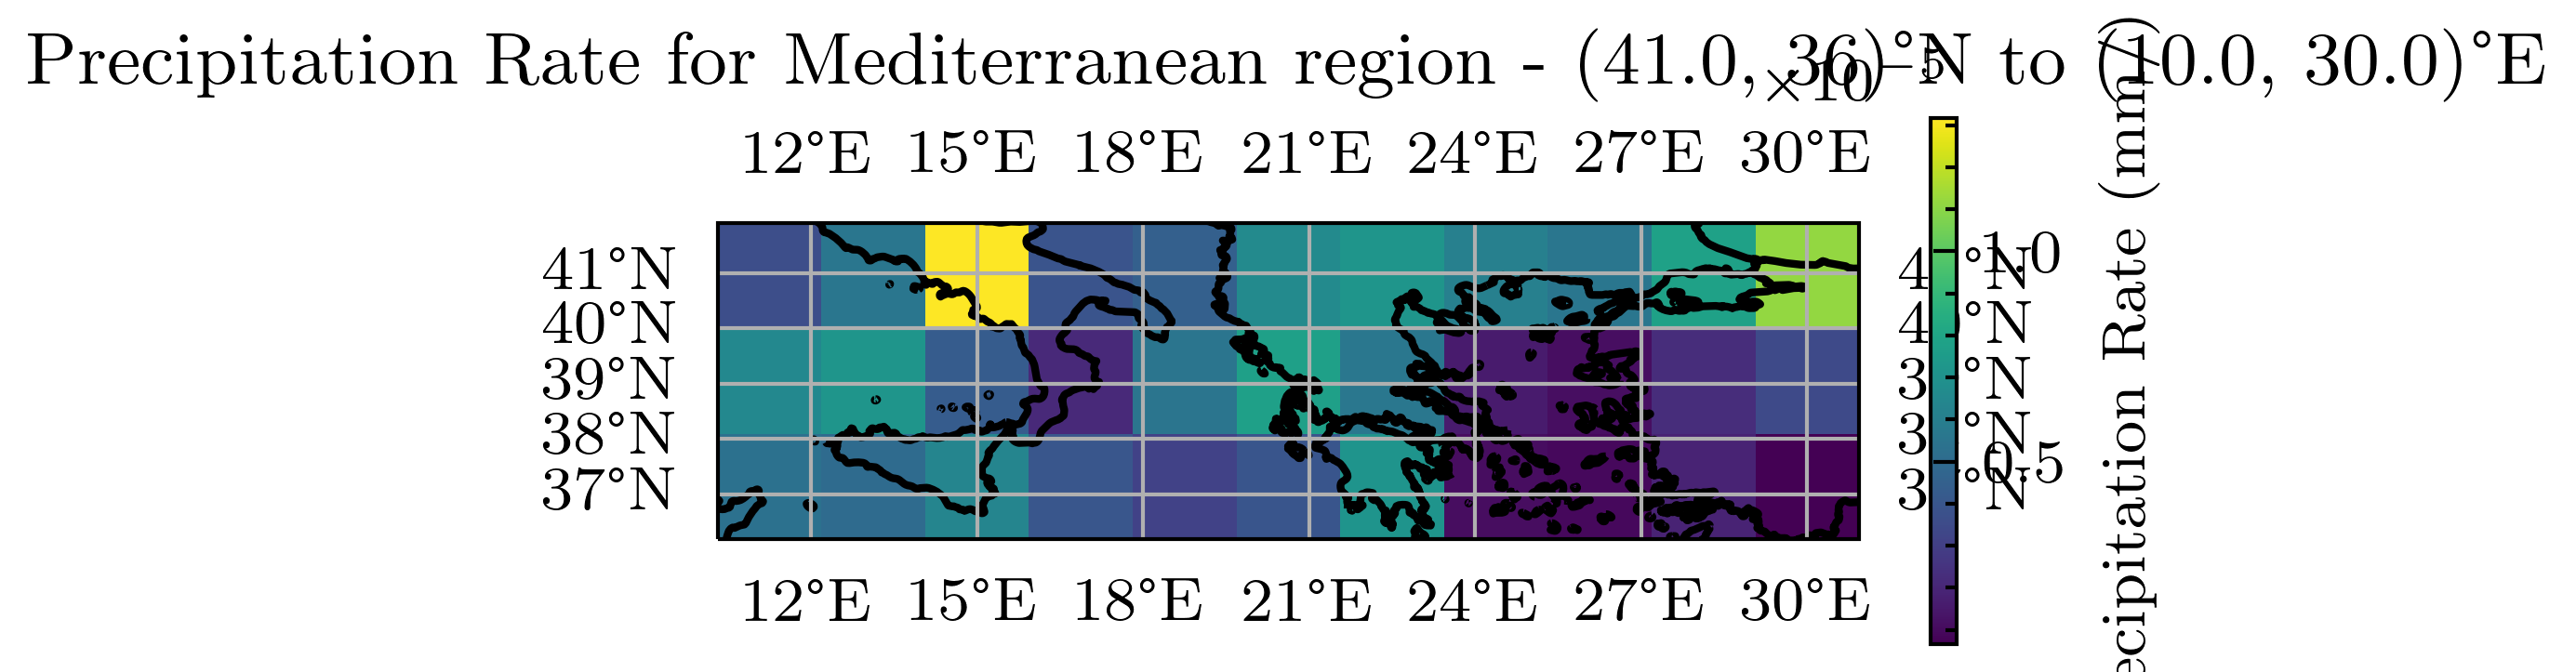

In [7]:
# Extract data at time=0
data_at_time_0 = med.sel(time=precip['time'][0])

# Create a figure and axis for the plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data on the map
pcm = data_at_time_0['prate'].plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Precipitation Rate (mm/)', 'shrink': 0.5})

# Add coastlines, gridlines, and a title
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title(f'Precipitation Rate for Mediterranean region - {lat_bounds}°N to {lon_bounds}°E')

# Show the plot
plt.show()


#### Denmark (DK)

In [8]:
lat_bounds = (60, 50)
lon_bounds = (2, 15)
dk = precip.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))

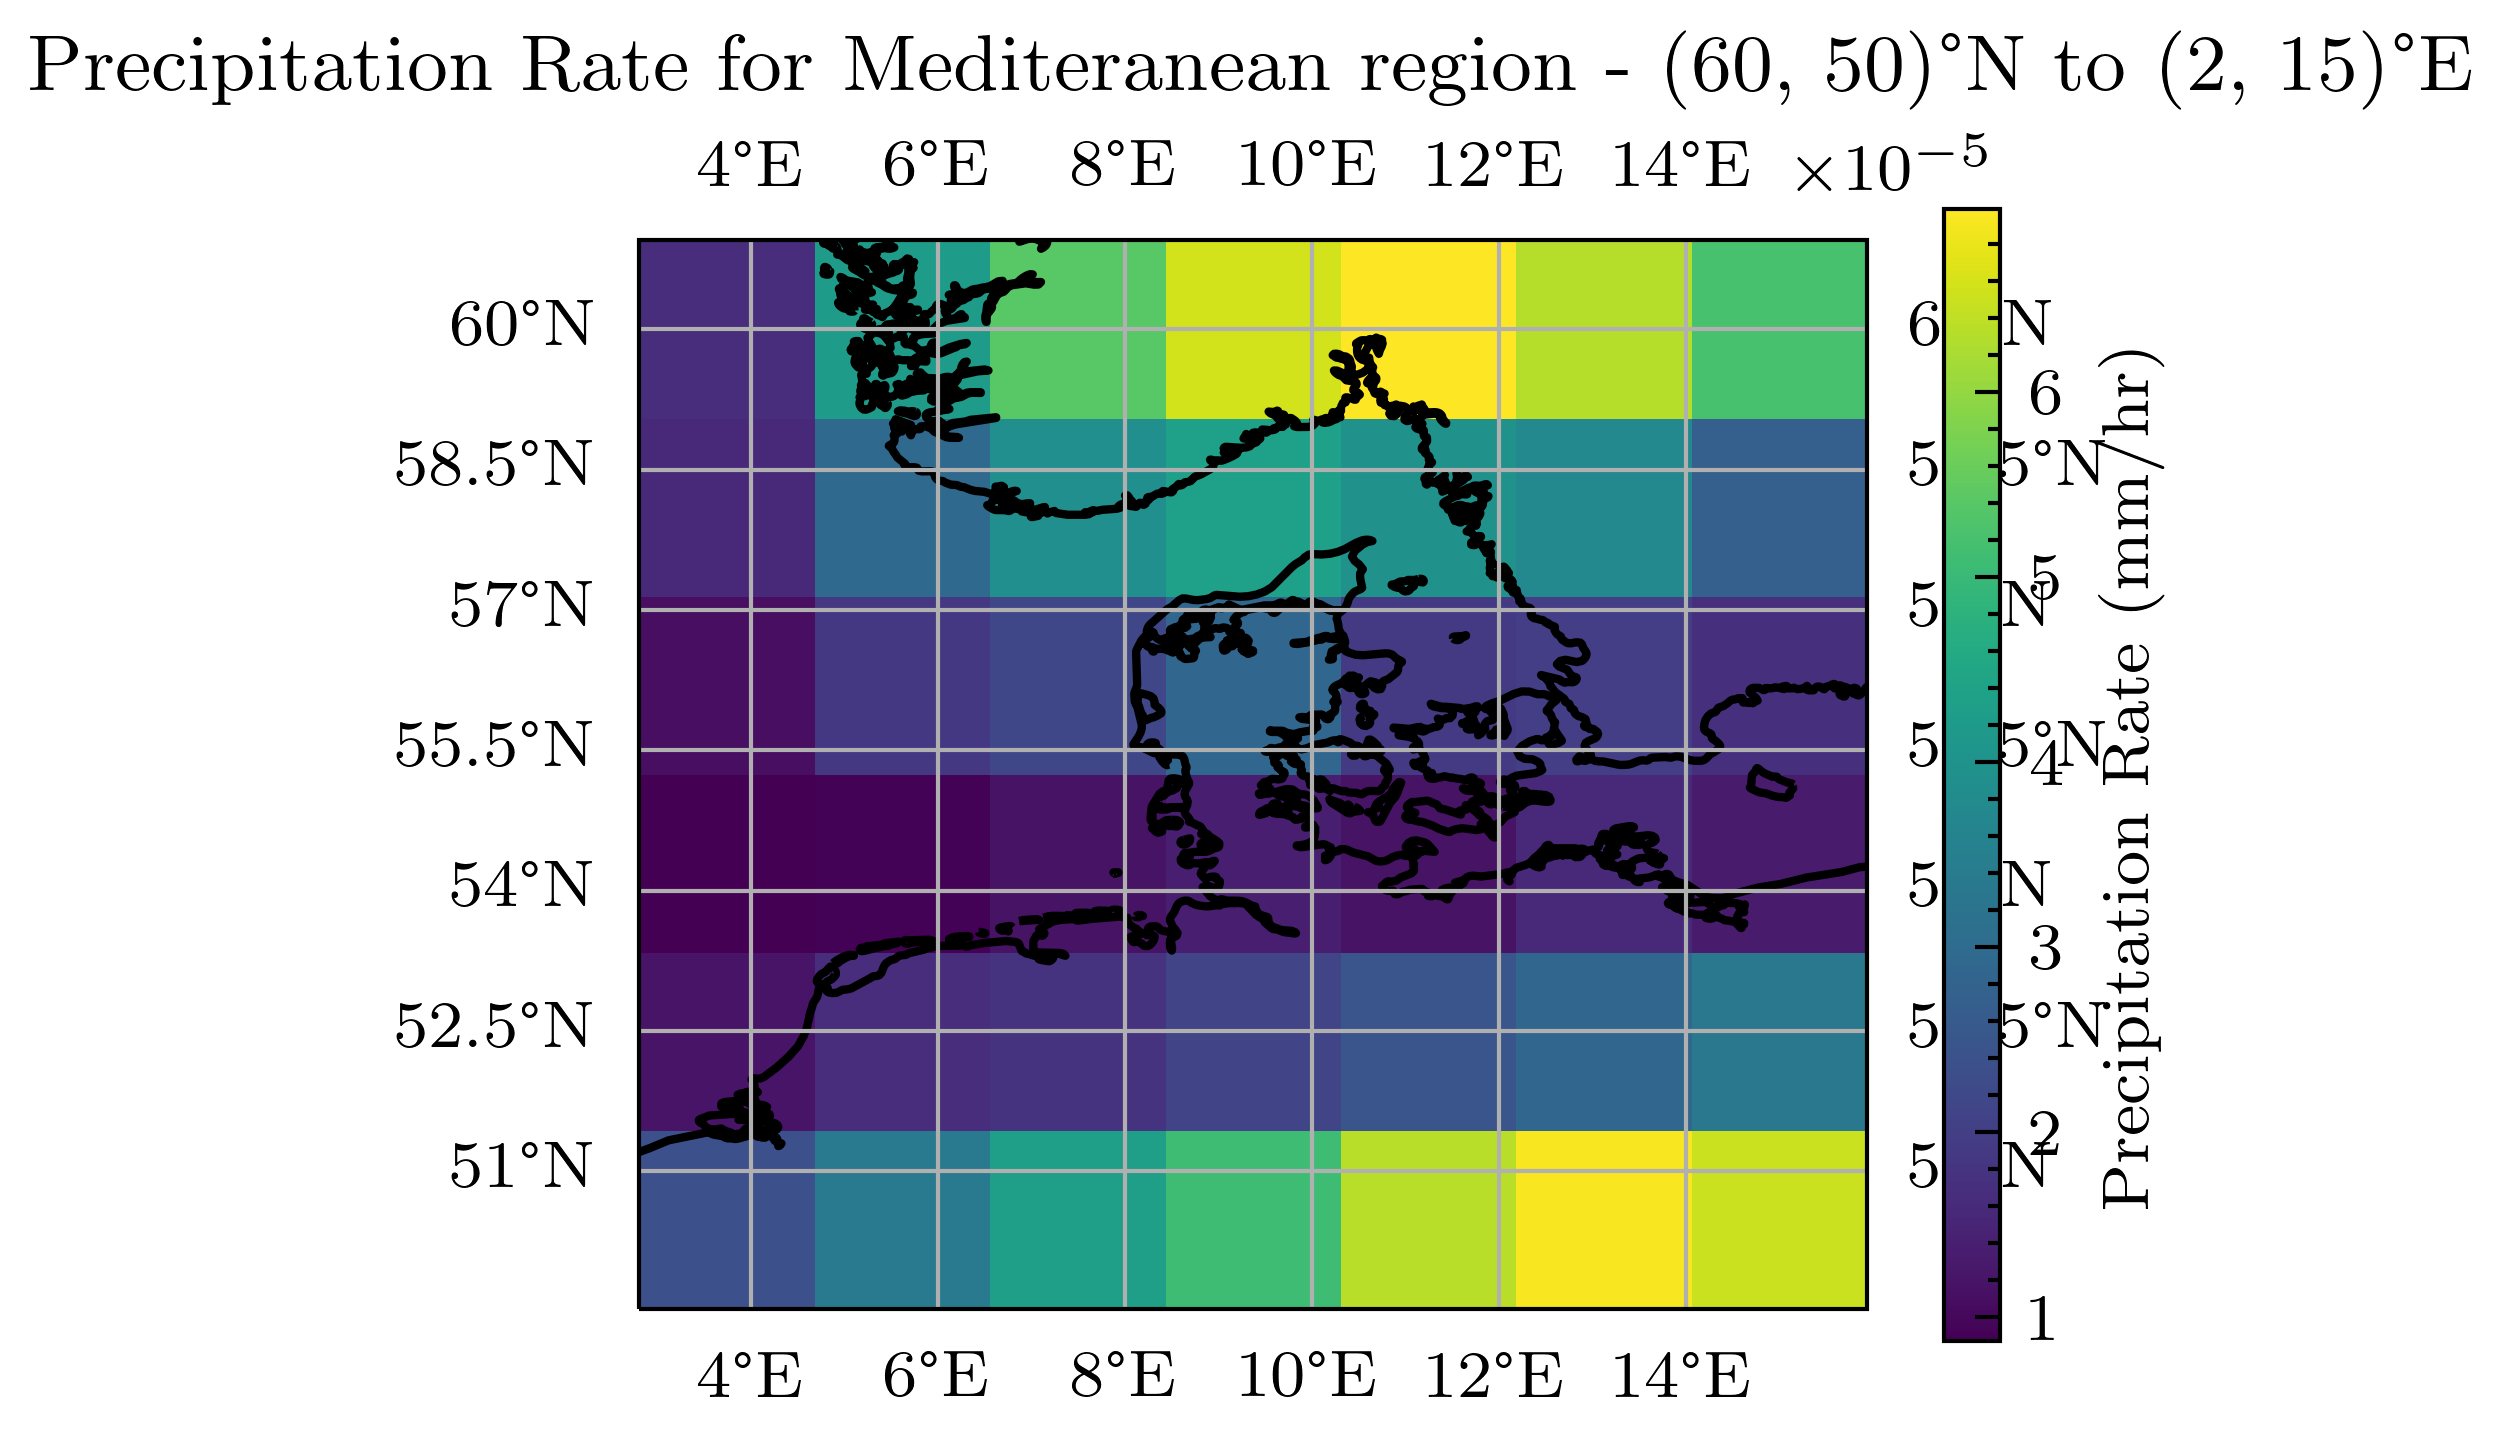

In [10]:
# Extract data at time=0
data_at_time_0 = dk.sel(time=med['time'][0])

# Create a figure and axis for the plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data on the map
data_at_time_0['prate'].plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Precipitation Rate (mm/hr)'})

# Add coastlines, gridlines, and a title
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title(f'Precipitation Rate for Mediteranean region - {lat_bounds}°N to {lon_bounds}°E')

# Show the plot
plt.show()

#### Create regional means

In [11]:
def areal_mean(cube):
    spatial_mean = cube.mean(dim=['lat', 'lon'])
    return spatial_mean

In [12]:
# Areal mean
med = areal_mean(med)
dk = areal_mean(dk)

#### Standardize the data (zero mean, unit variance)

In [15]:
NAO = (nao['nao'] - np.mean(nao['nao']))/np.std(nao['nao'])
MED = (med['prate'] - np.mean(med['prate']))/np.std(med['prate'])
DK = (dk['prate'] - np.mean(dk['prate']))/np.std(dk['prate'])
ENSO = (enso['enso'] - np.mean(enso['enso']))/np.std(enso['enso'])
#AO = (ao - np.mean(ao))/np.std(ao)

In [16]:
NAO, MED, DK, ENSO = NAO.to_numpy(), MED.to_numpy(), DK.to_numpy(), ENSO.to_numpy()

#### Detrend

In [17]:
NAO = signal.detrend(NAO.data)
MED = signal.detrend(MED.data)
DK = signal.detrend(DK.data)
ENSO = signal.detrend(ENSO.data)
#AO = signal.detrend(AO)

In [18]:
np.coDK

array([ 0.14769375, -0.36179125, -0.5025448 ,  1.9492797 ,  1.2745012 ,
       -0.79161084,  0.32852656,  0.0810241 ,  0.4943996 , -1.2160815 ,
        1.172852  ,  0.6282571 ,  0.71082574,  1.5780339 ,  0.6780499 ,
        1.0795516 ,  1.3282542 , -0.29392338,  0.2729788 , -1.0986416 ,
       -0.90737194, -0.6381406 , -0.9625658 , -0.79781485,  0.507763  ,
       -0.9557344 , -2.5181422 ,  0.12220575,  0.35733646, -0.4825195 ,
        1.5501851 , -0.30938303,  0.3793617 , -2.4060926 , -1.3204085 ,
        0.4953593 , -0.2918468 ,  0.8068469 ,  1.1312656 , -0.42840457,
       -0.33186117, -0.26845908, -0.84765565, -0.8758491 , -1.8566532 ,
       -1.8326771 , -1.4667952 , -0.5219977 ,  0.48976174, -0.43496284,
       -0.59247196,  0.01406268,  0.40788293, -0.83732224,  1.2002909 ,
       -0.7233546 ,  0.7858919 ,  1.9737753 ,  0.9353575 ,  0.70484567,
       -0.17551783,  0.9312644 ,  0.7103863 , -1.1301242 ,  1.5937827 ,
       -0.32694593,  0.91127217,  0.69044936, -0.6523216 ,  0.73

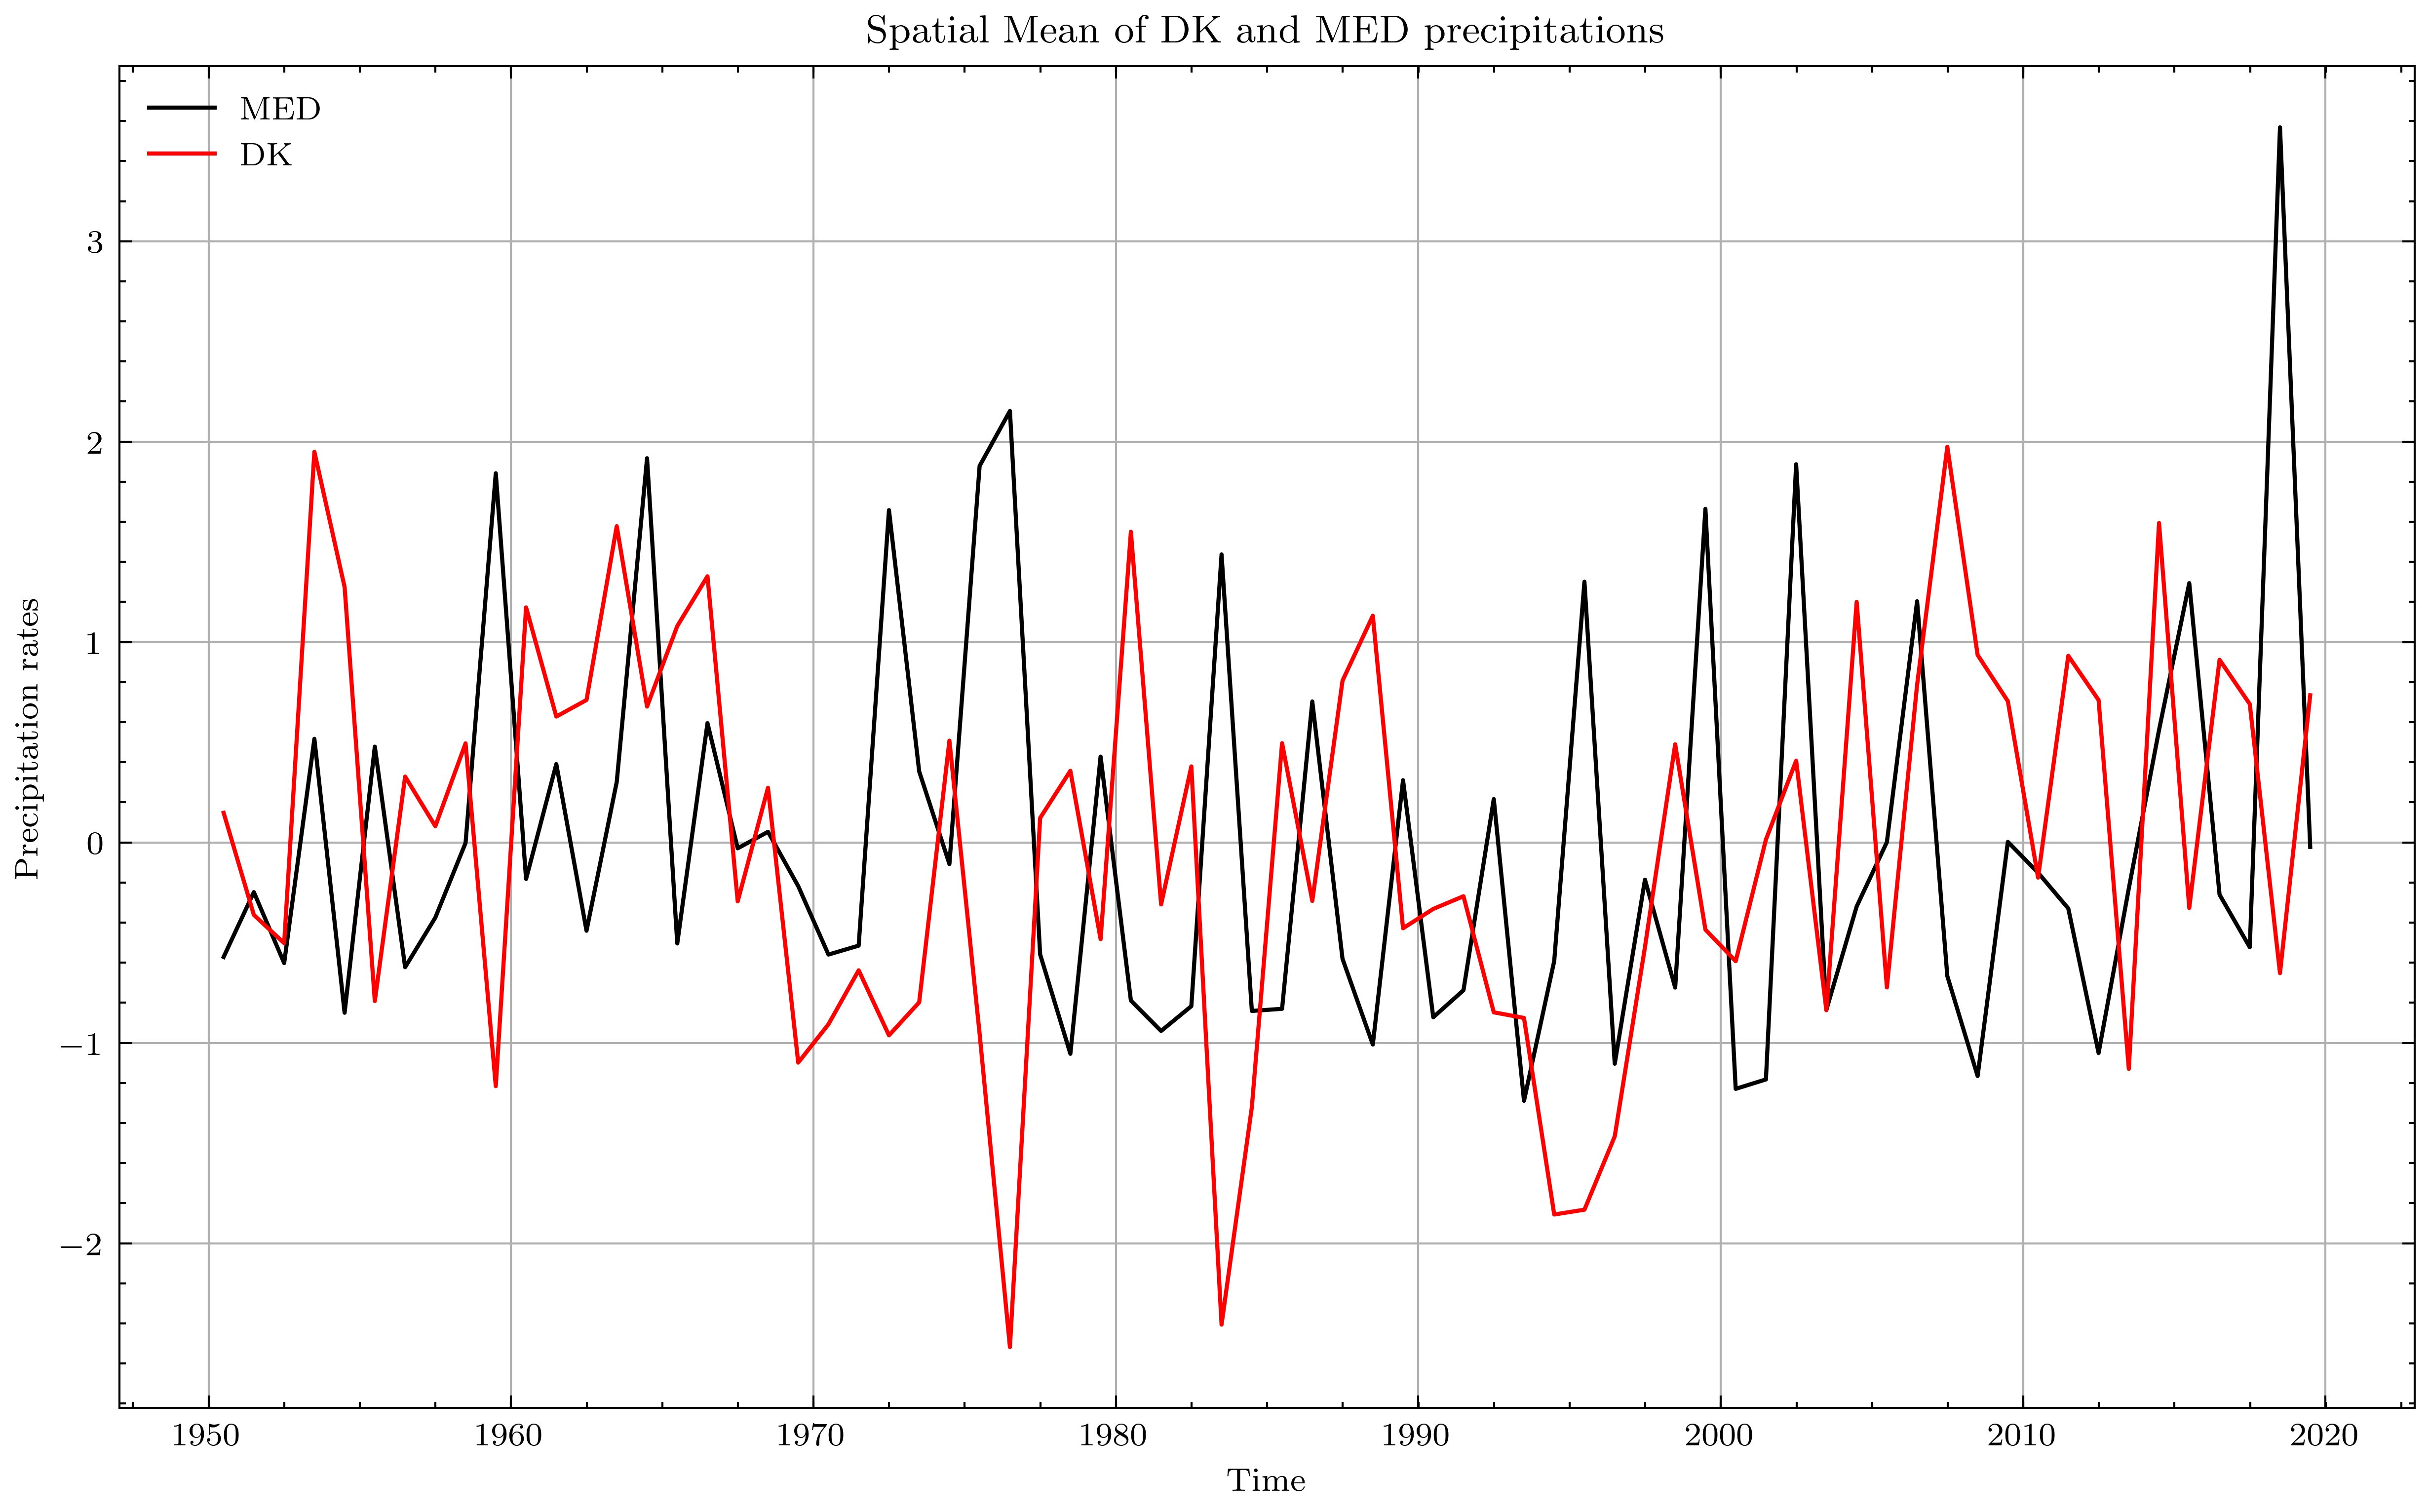

In [14]:
# Plot the time series
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(med['time'], MED, linestyle='-', label='MED')
plt.plot(dk['time'], DK, linestyle='-', label='DK')


# Add labels and a title
plt.xlabel('Time')
plt.ylabel('Precipitation rates')
plt.title('Spatial Mean of DK and MED precipitations')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


## Loading HGT data

In [15]:
file = '../data/hgt.mon.mean.nc'
ds = xr.open_dataset(file)

In [16]:
# Extract the time coordinate variable from the Denmark data (assuming you have it)
dk_time = dk['time']

# Find the overlapping time period
overlap_start = max(dk_time.min(), ds['time'].min())
overlap_end = min(dk_time.max(), ds['time'].max())

# Select the overlapping time period in the pressure data
lat_bounds, lon_bounds = (90, -90), (280, 360) # Atlantic 

#pressure = ds.sel(time=slice(overlap_start, overlap_end))
pressure = ds.sel(time=slice(overlap_start, overlap_end), lat=slice(*lat_bounds), lon=slice(*lon_bounds))


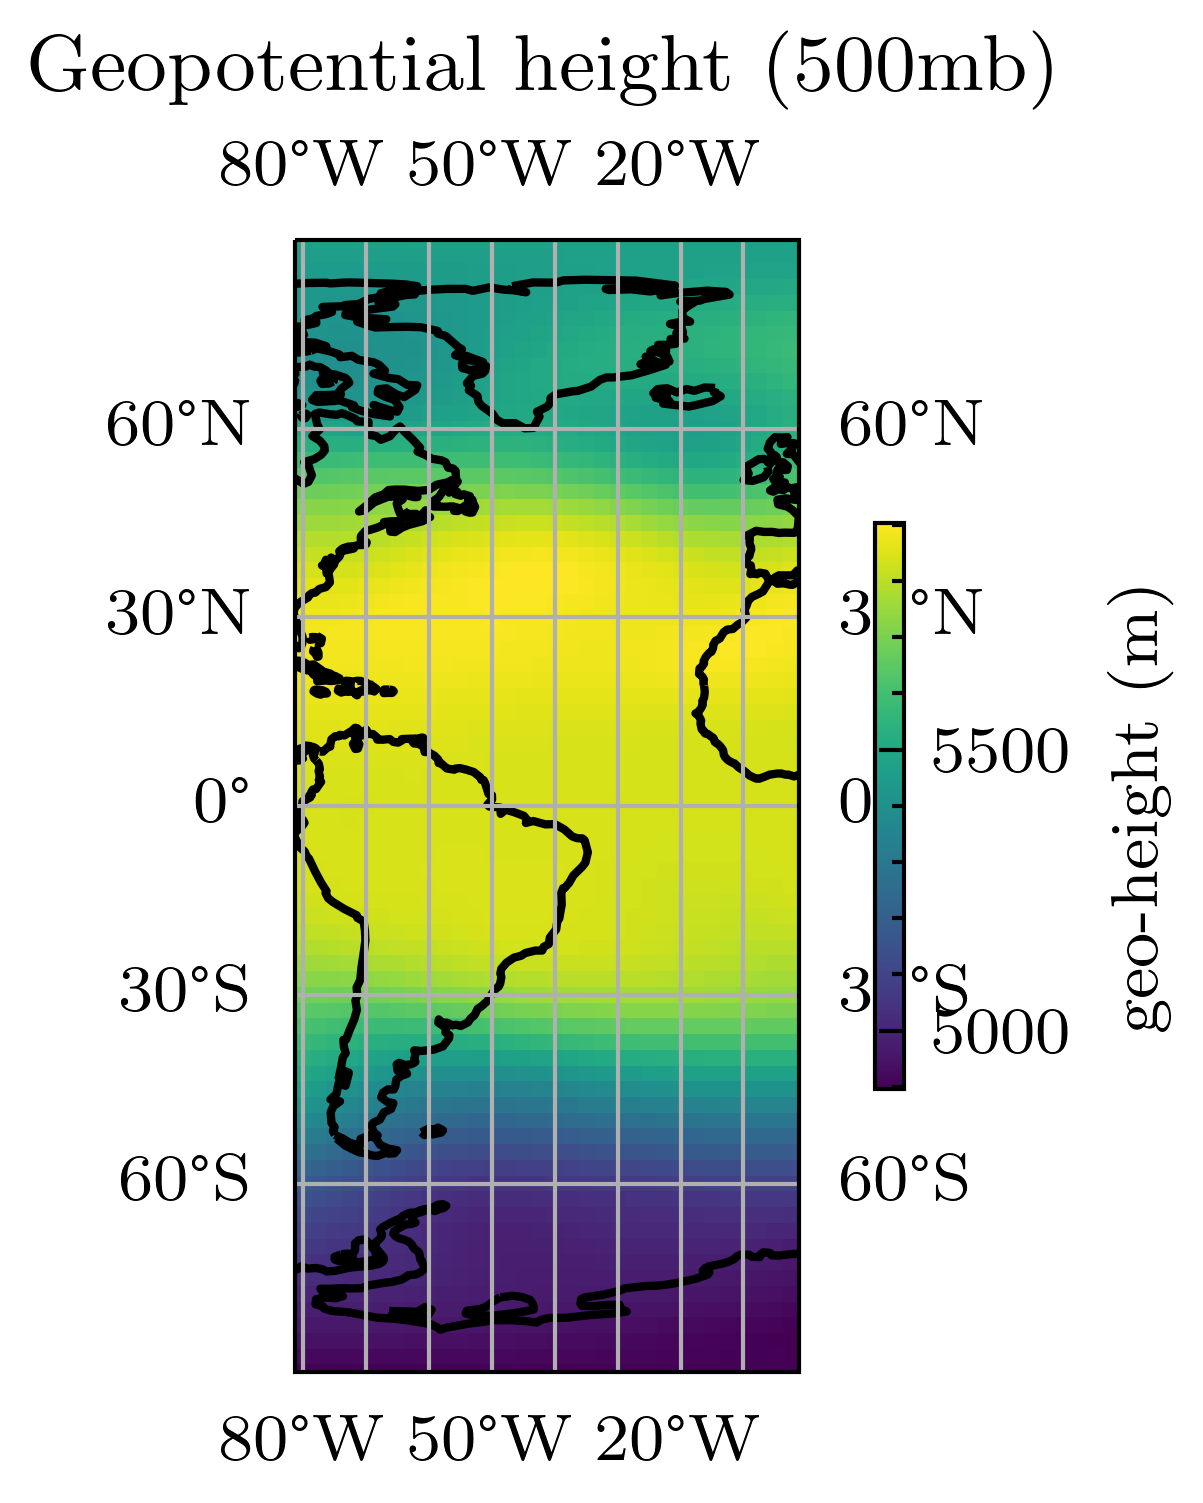

In [17]:
# Extract data at time=0
data_at_time_0 = pressure.sel(time=pressure['time'][0])
data_at_time_0 = data_at_time_0.sel(level=500)

# Create a figure and axis for the plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data on the map
data_at_time_0['hgt'].plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'geo-height (m)', 'shrink':0.5})

# Add coastlines, gridlines, and a title
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title(f'Geopotential height (500mb)')

# Show the plot
plt.show()

In [18]:
# Select the level=500, and the months of June, July, and August
summer_pressure = pressure.sel(level=500, time=pressure['time.month'].isin([6, 7, 8]))

# Calculate the yearly mean for the selected months and level
summer_pressure_mean = summer_pressure['hgt'].groupby('time.year').mean(dim='time')

# Convert the xarray DataArray to a NumPy array
data_pressure = summer_pressure_mean.values
original_shape = data_pressure.shape
data_pressure = data_pressure.reshape(original_shape[0], -1)

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
U, X, Y, Z = data_pressure, MED, DK, NAO
U = sc.fit_transform(U)

## Confounding Analysis

### Principal Component Analysis

In [20]:
ncp = 10
confidence_level = 0.95
pca = PCA(n_components=ncp)
U_pca_adjustment = pca.fit_transform(U)
causal_effect_z, uncertainty_z = causal_effect_estimation(X, Y, Z.reshape(-1, 1), confidence_level = confidence_level)
causal_effect_adjusted, uncertainty_adjusted = causal_effect_estimation(X, Y, U_pca_adjustment, confidence_level = confidence_level)
mse_nao_adjusted = np.mean((NAO - LinearRegression().fit(U_pca_adjustment, NAO).predict(U_pca_adjustment))**2)

In [21]:
results = {}
for method in ['PCA', 'PLS', 'ICA'] :
    cca = ConfounderCA(dr_method=method)
    confounders = cca.fit_transform(U, X, Y, threshold=0.05)
    weights = cca.weights.T

    corr = np.abs(np.corrcoef(np.hstack((Z[:,None], confounders)).T)[0, 1:])  
    causal_effect, uncertainty = causal_effect_estimation(X, Y, confounders, confidence_level = confidence_level)
    mse_nao = np.mean((NAO - LinearRegression().fit(confounders, NAO).predict(confounders))**2)
    are = np.abs(causal_effect_z - causal_effect_adjusted)/np.abs(causal_effect_z - causal_effect_adjusted)
    
    results[method] = {'corr':np.round(corr,3), 'MSE NAO':np.round(mse_nao, 3), 'ARE':np.round(are, 3), 'CE':np.round(causal_effect, 3), 'uncertainty':np.round(uncertainty, 3), 'weights':np.round(weights, 3), 'confounder':np.round(confounders, 3)}

/home/homer/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [22]:
results['PCA adjustment'] = {'corr':'--', 'MSE NAO':np.round(mse_nao_adjusted, 3), 'ARE':1, 'CE':np.round(causal_effect_adjusted, 3), 'uncertainty':np.round(uncertainty_adjusted, 3), 'weights':"", 'confounder':""}

In [23]:
# Create DataFrames for corr values
tab_sum = pd.DataFrame(results).round()[:5]
print(tab_sum.to_latex())

\begin{tabular}{lllll}
\toprule
{} &             PCA &             PLS &                           ICA & PCA adjustment \\
\midrule
corr        &  [0.174, 0.747] &  [0.808, 0.047] &  [0.691, 0.276, 0.051, 0.445] &             -- \\
MSE NAO     &           0.402 &           0.305 &                          0.24 &          0.154 \\
ARE         &             1.0 &             1.0 &                           1.0 &              1 \\
CE          &          -0.005 &          -0.055 &                         0.032 &           0.05 \\
uncertainty &            0.19 &           0.217 &                         0.207 &          0.215 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_27533/4067730272.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab_sum.to_latex())


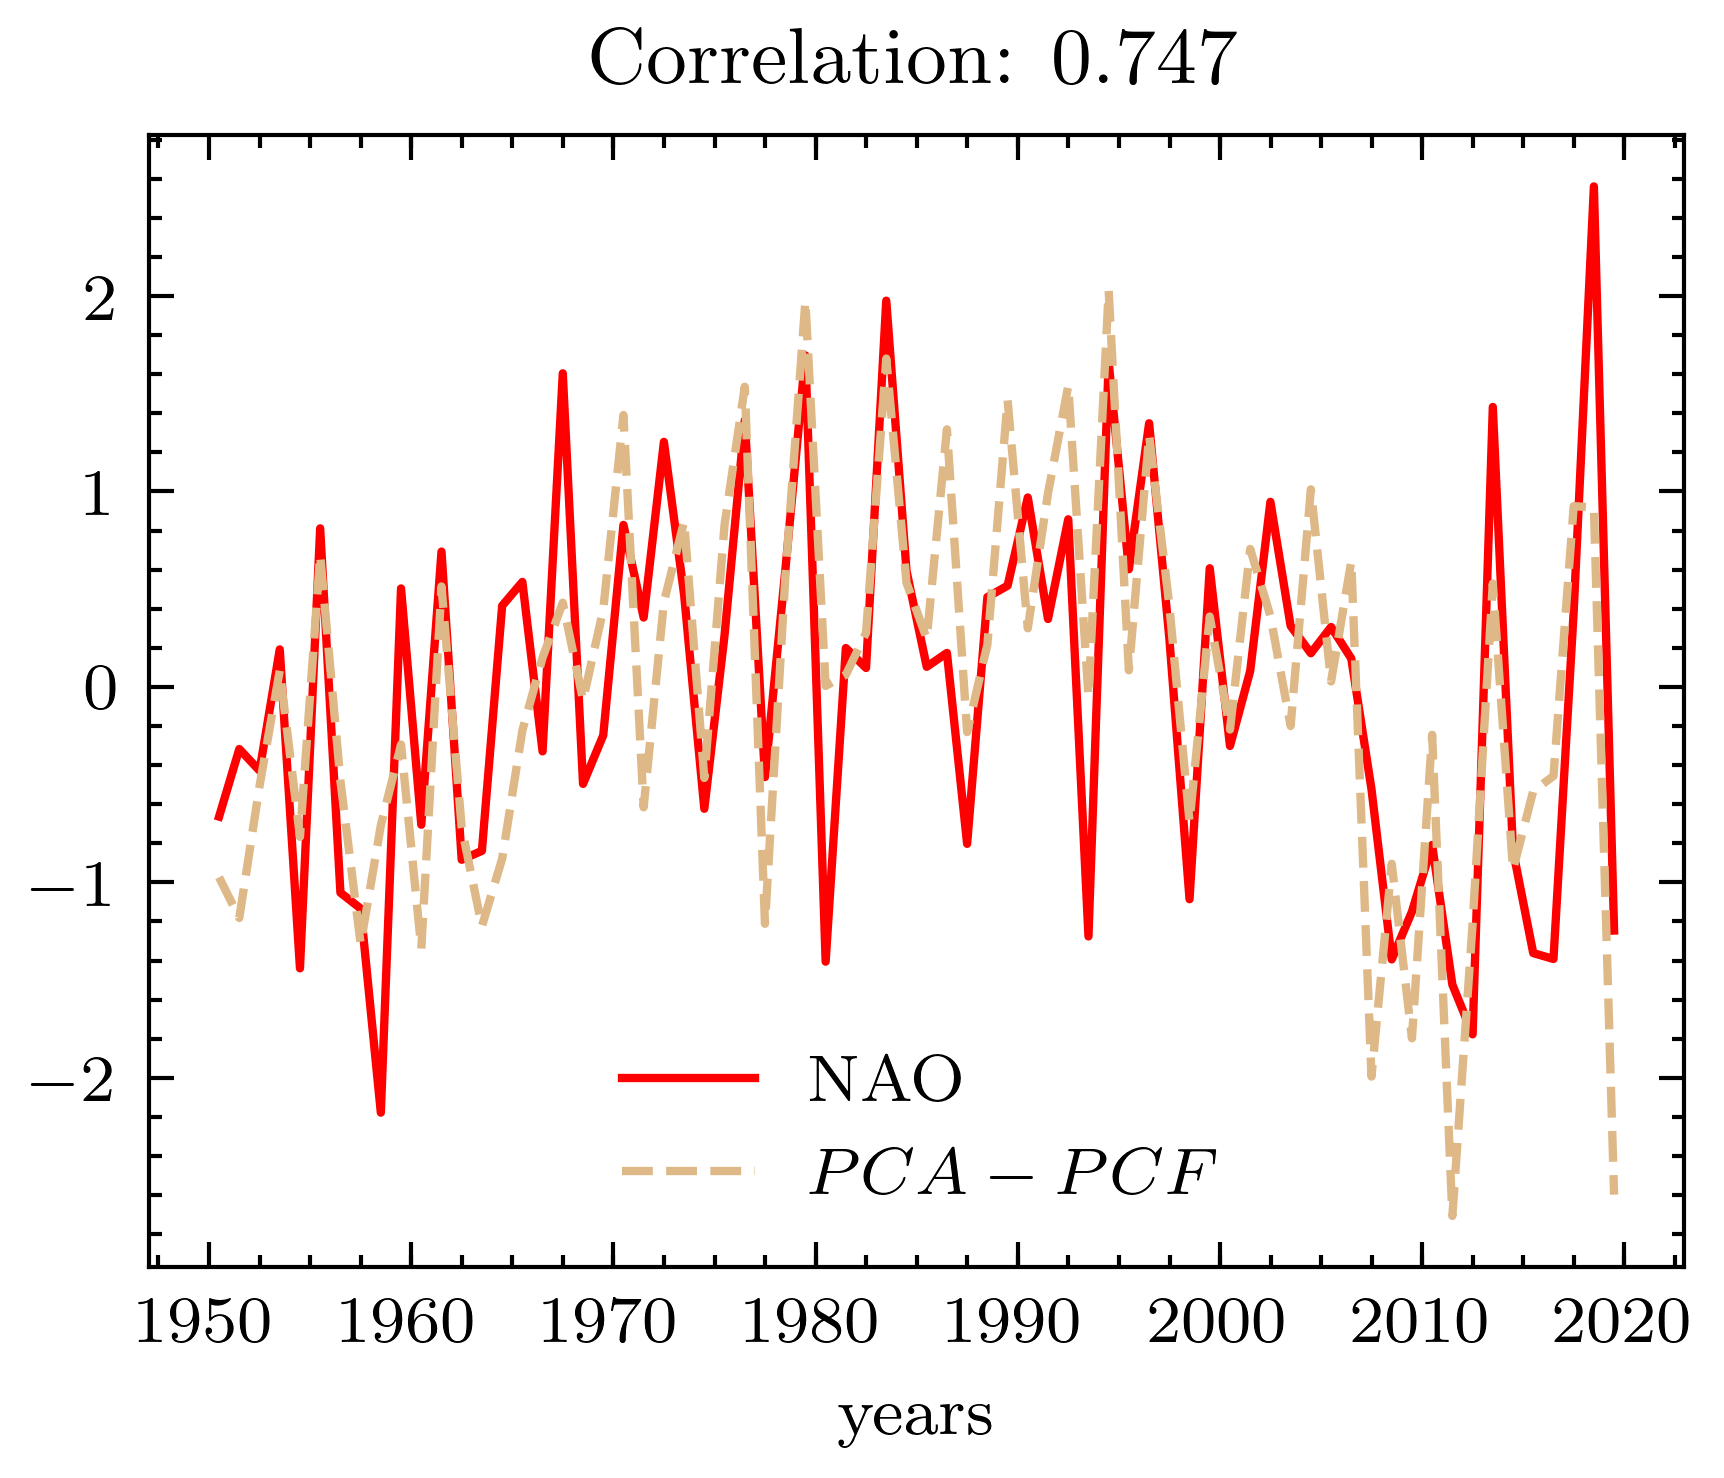

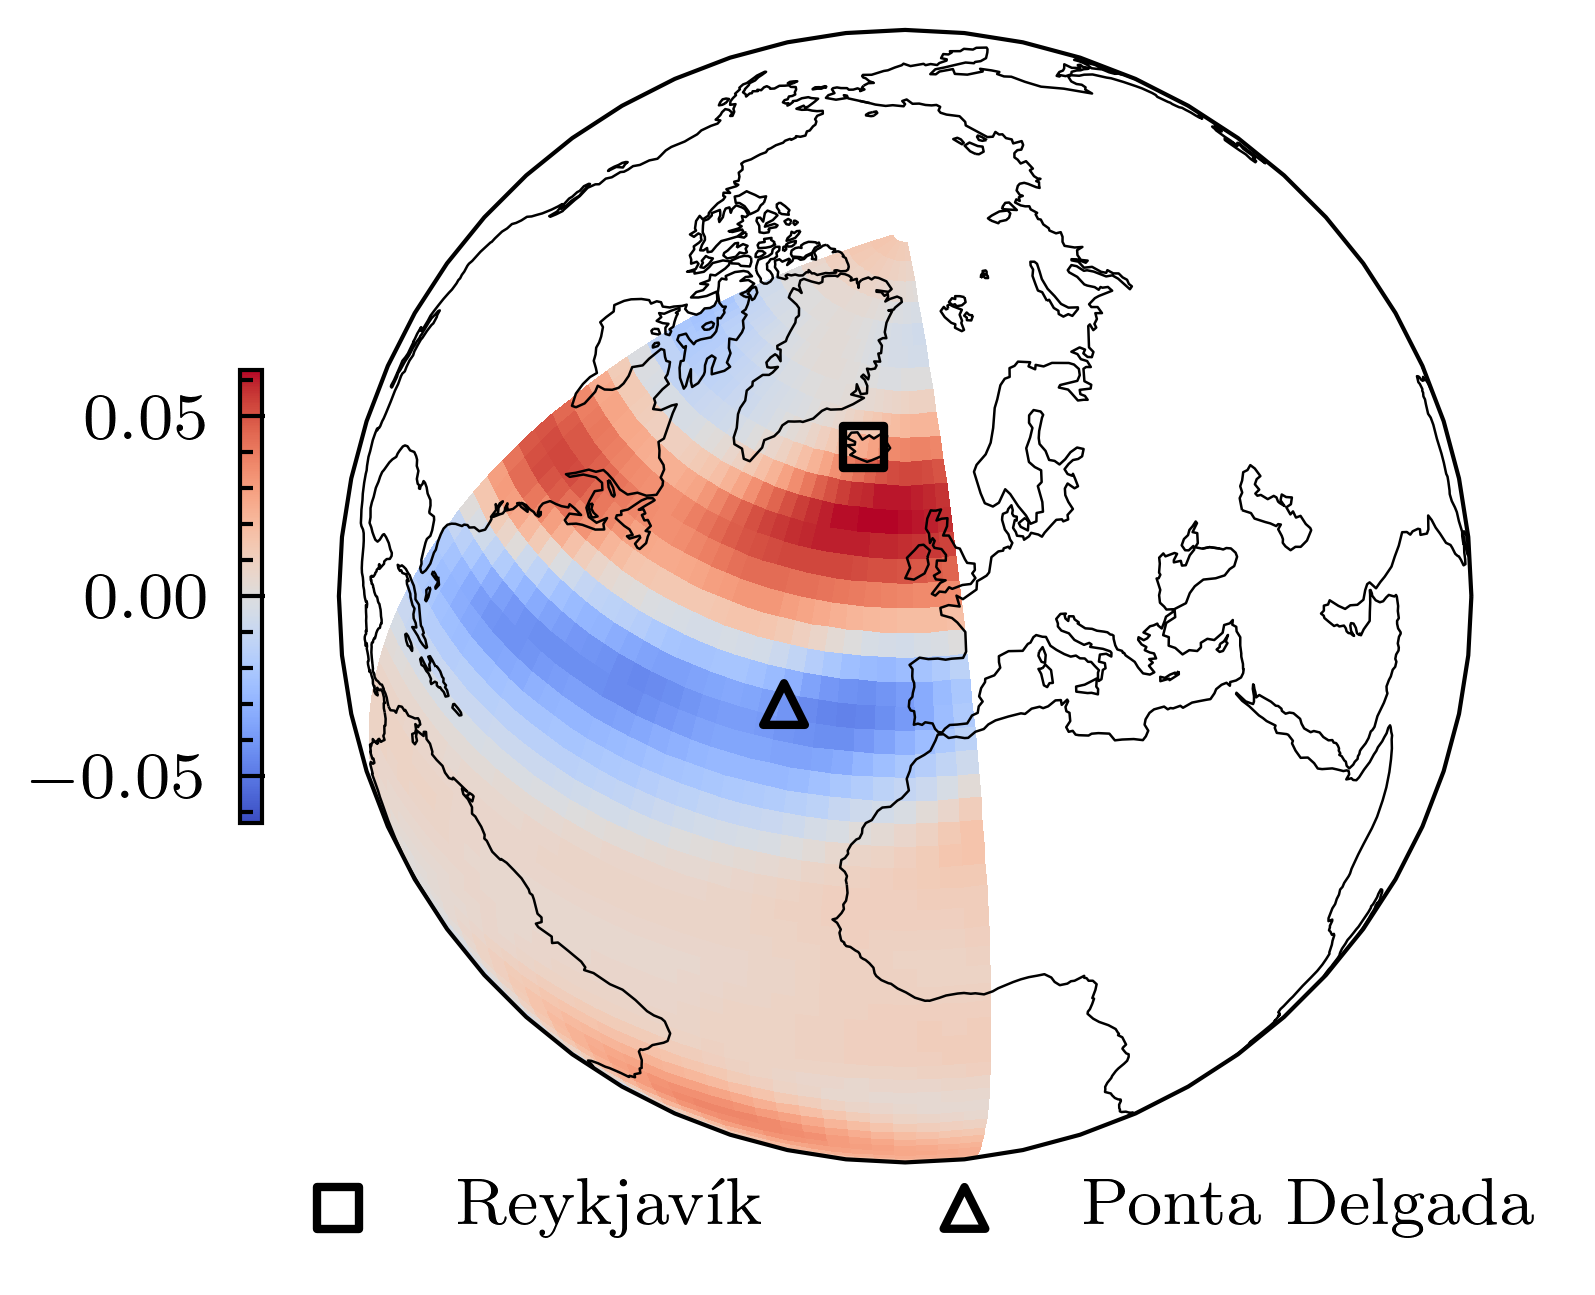

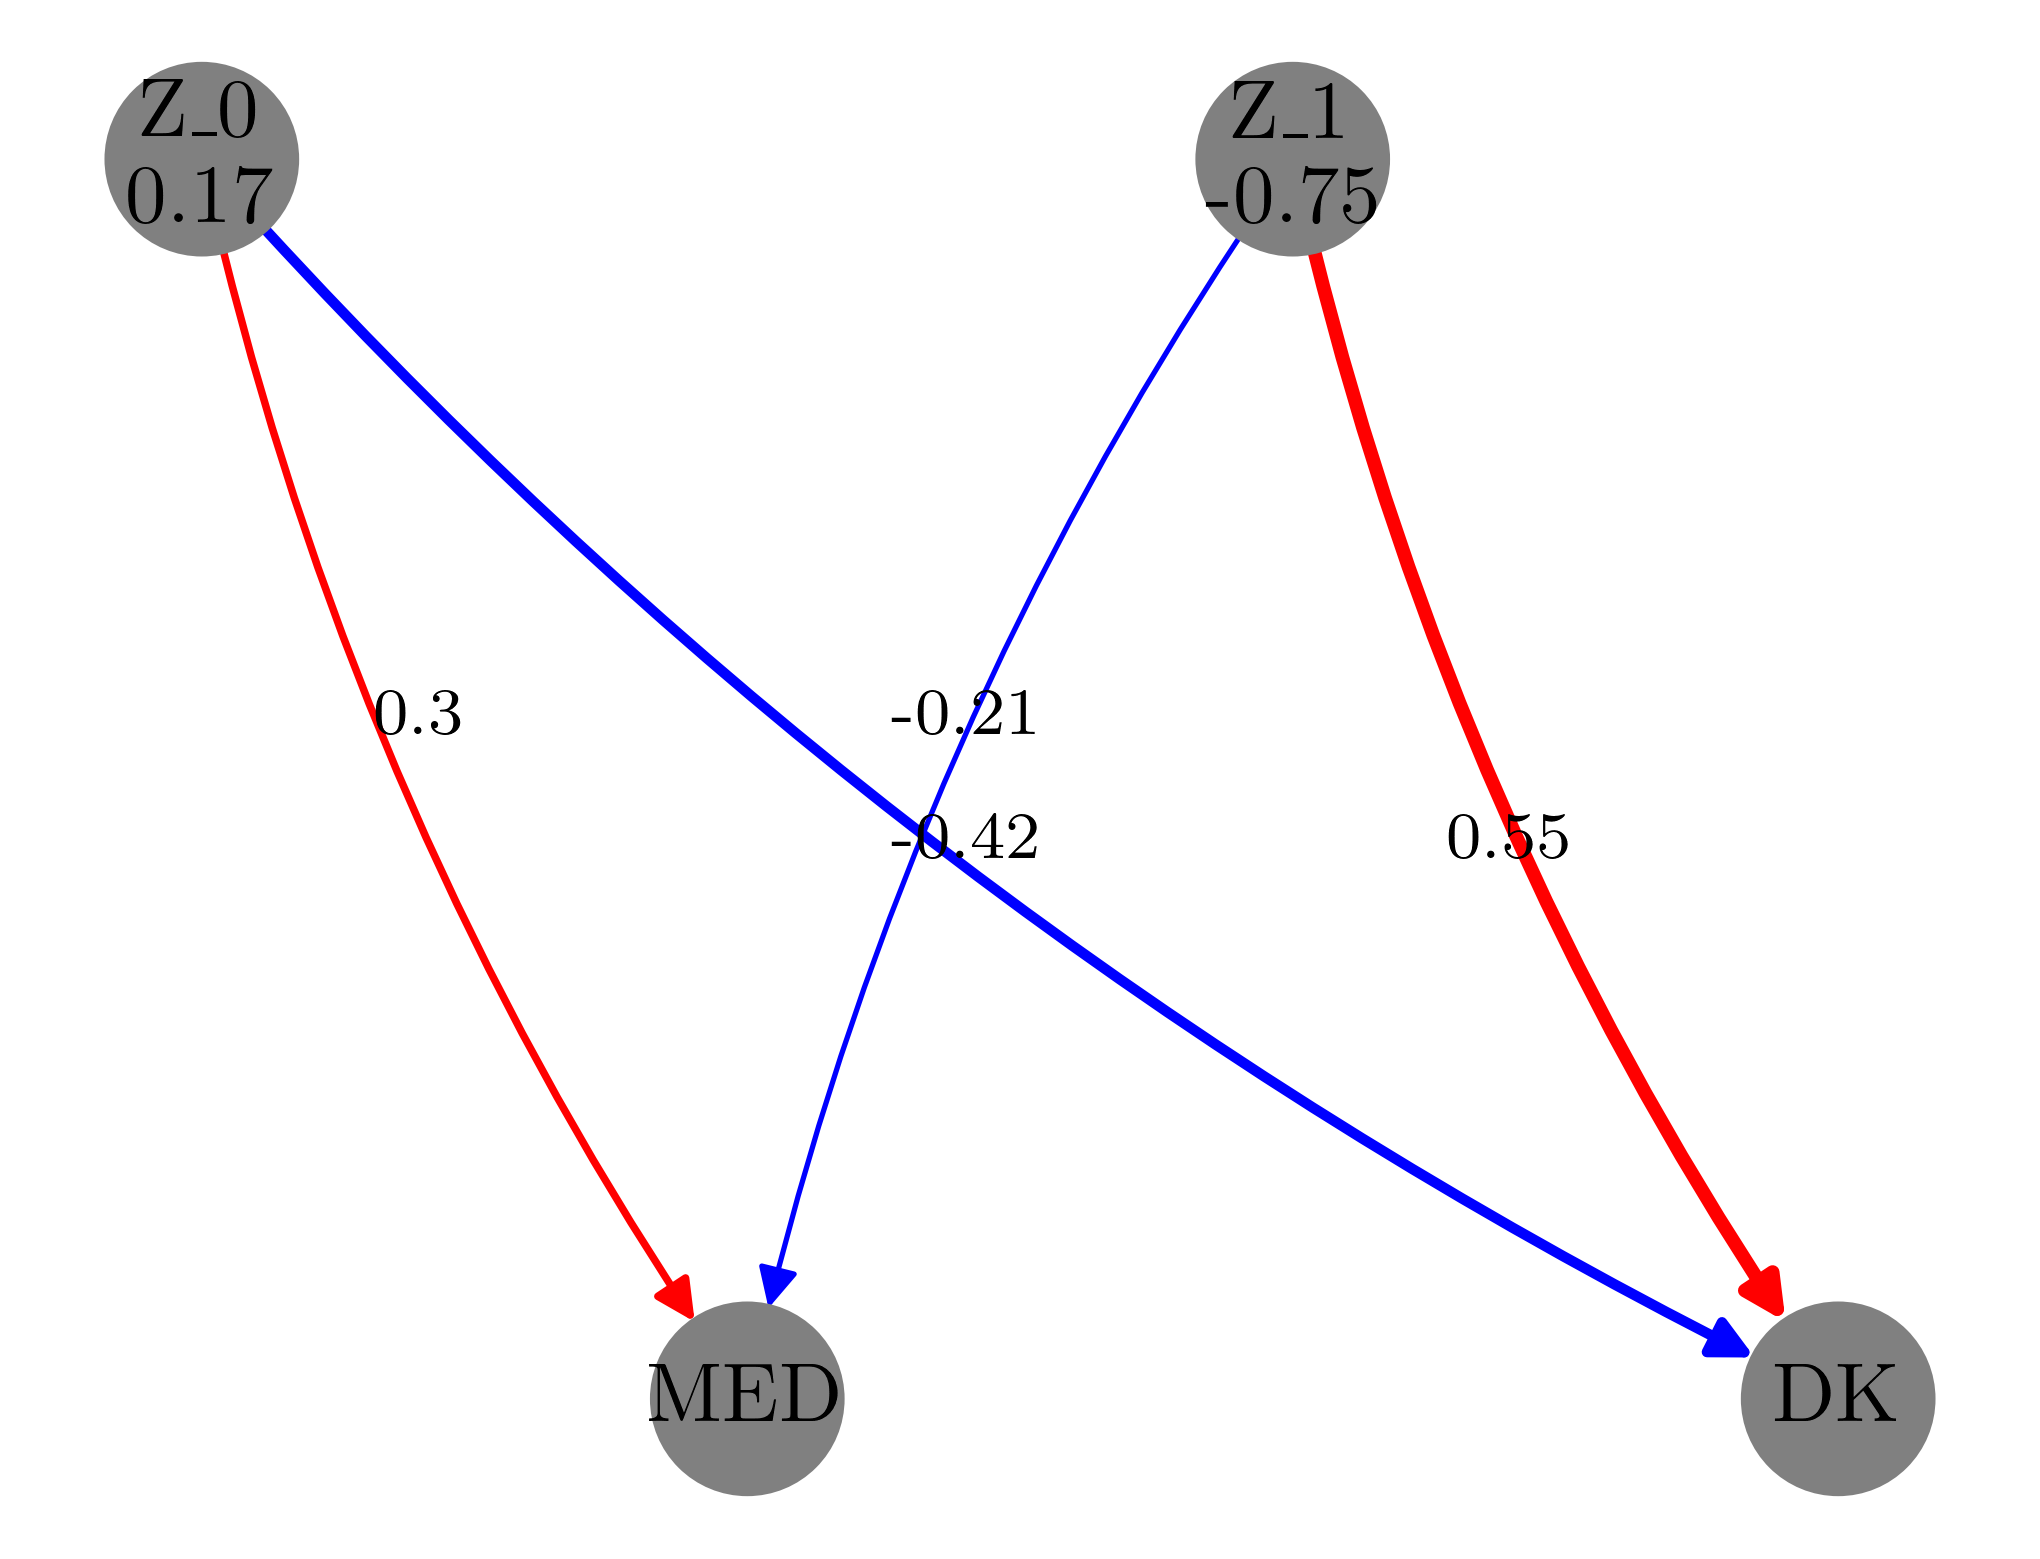

In [24]:
method = 'PCA'
plot_corr(results, Z, cp=1, method=method, time=med['time'].to_numpy())
plot_weights(results, cp=0, method=method, latitudes = pressure['lat'], longitudes = pressure['lon'], original_shape=original_shape)
confounders = results[method]['confounder']
coef_MED = LinearRegression().fit(np.hstack((confounders, DK[:,None])), MED).coef_.round(2)
coef_DK = LinearRegression().fit(np.hstack((confounders, MED[:,None])), DK).coef_.round(2)
plot_graph(results, coef_MED, coef_DK, method, NAO=Z)

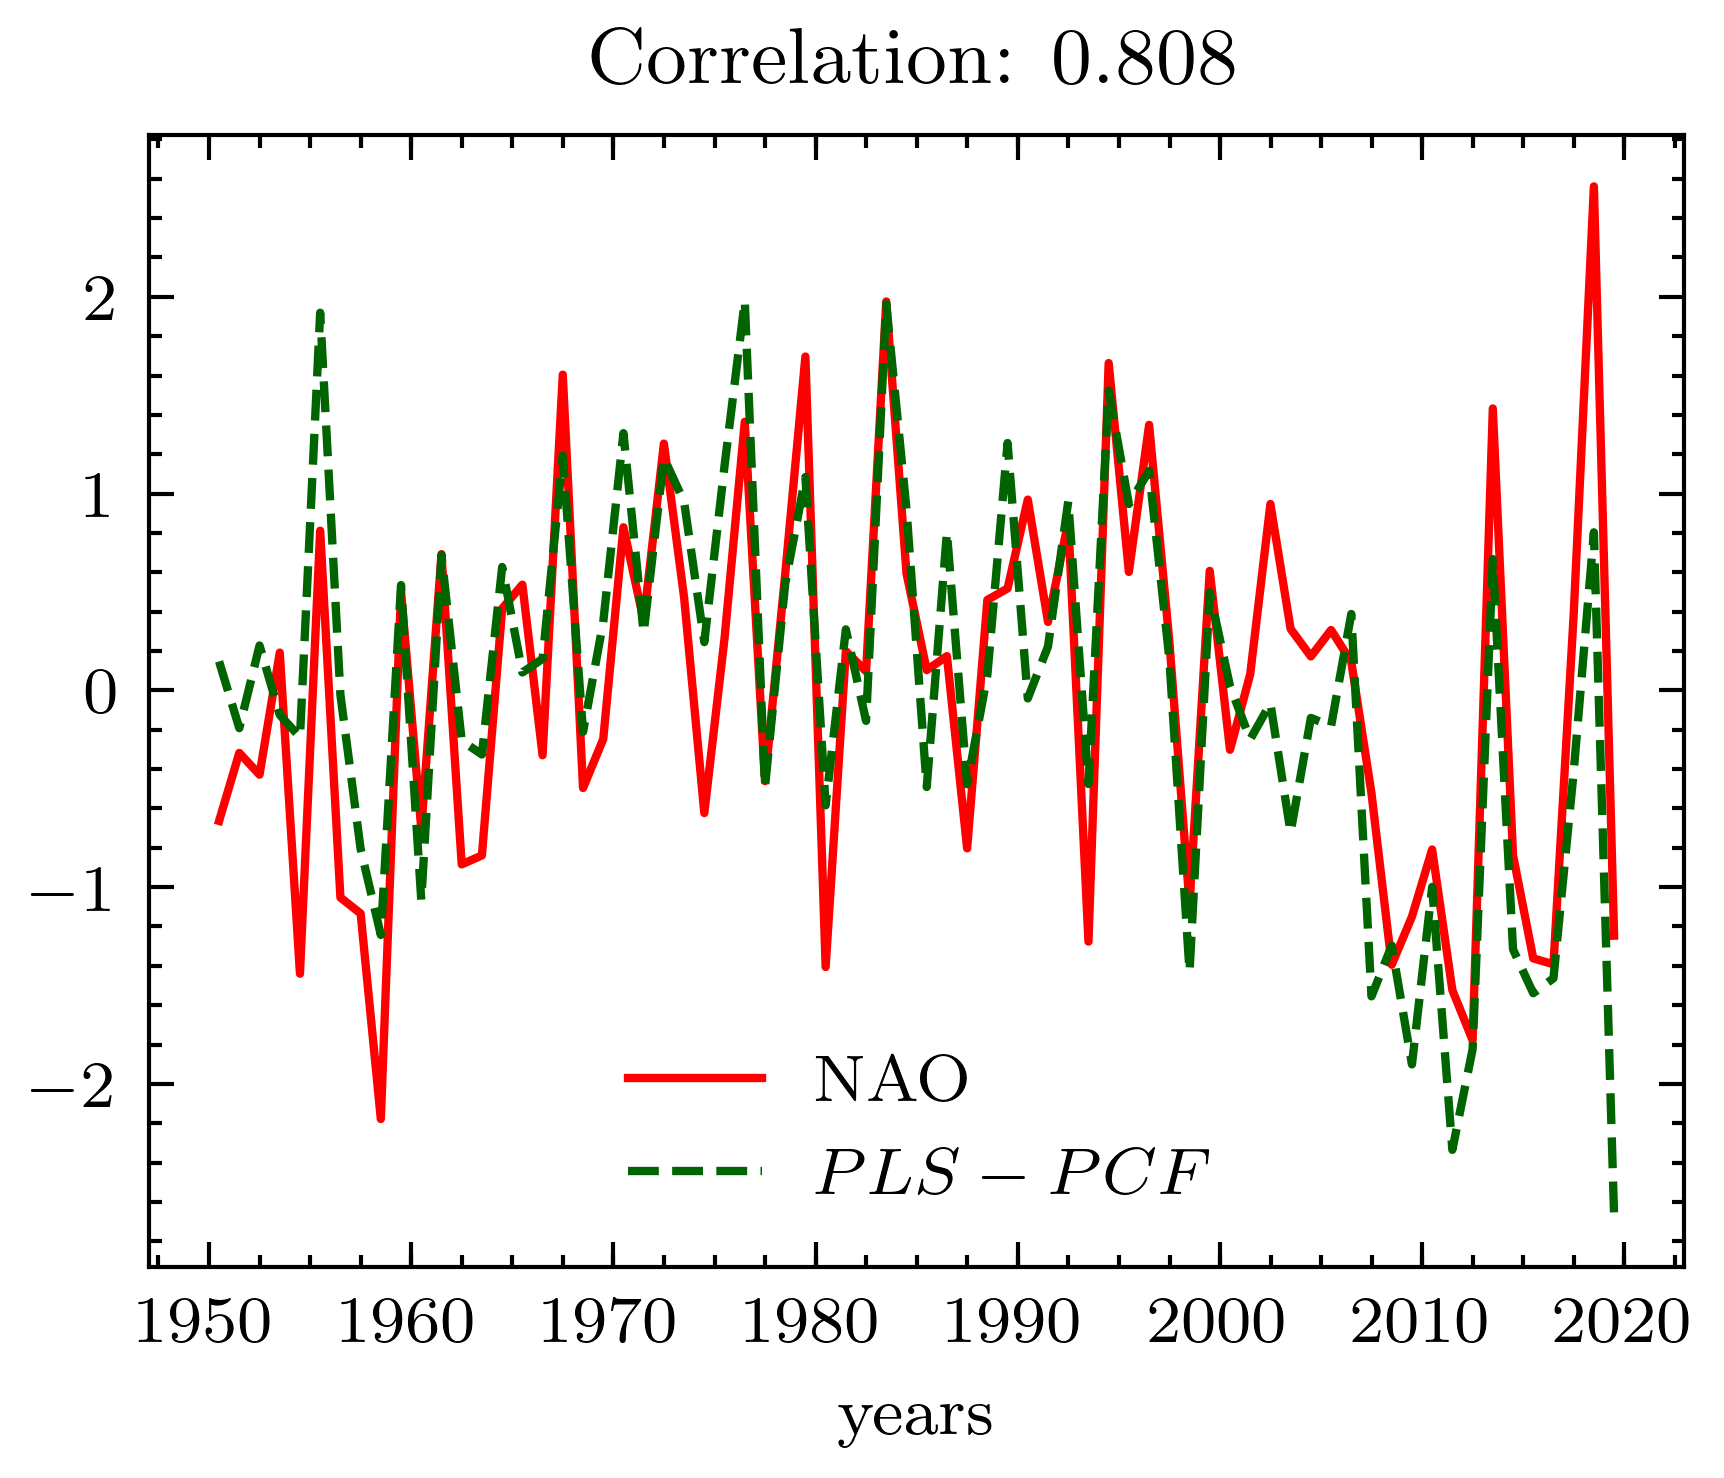

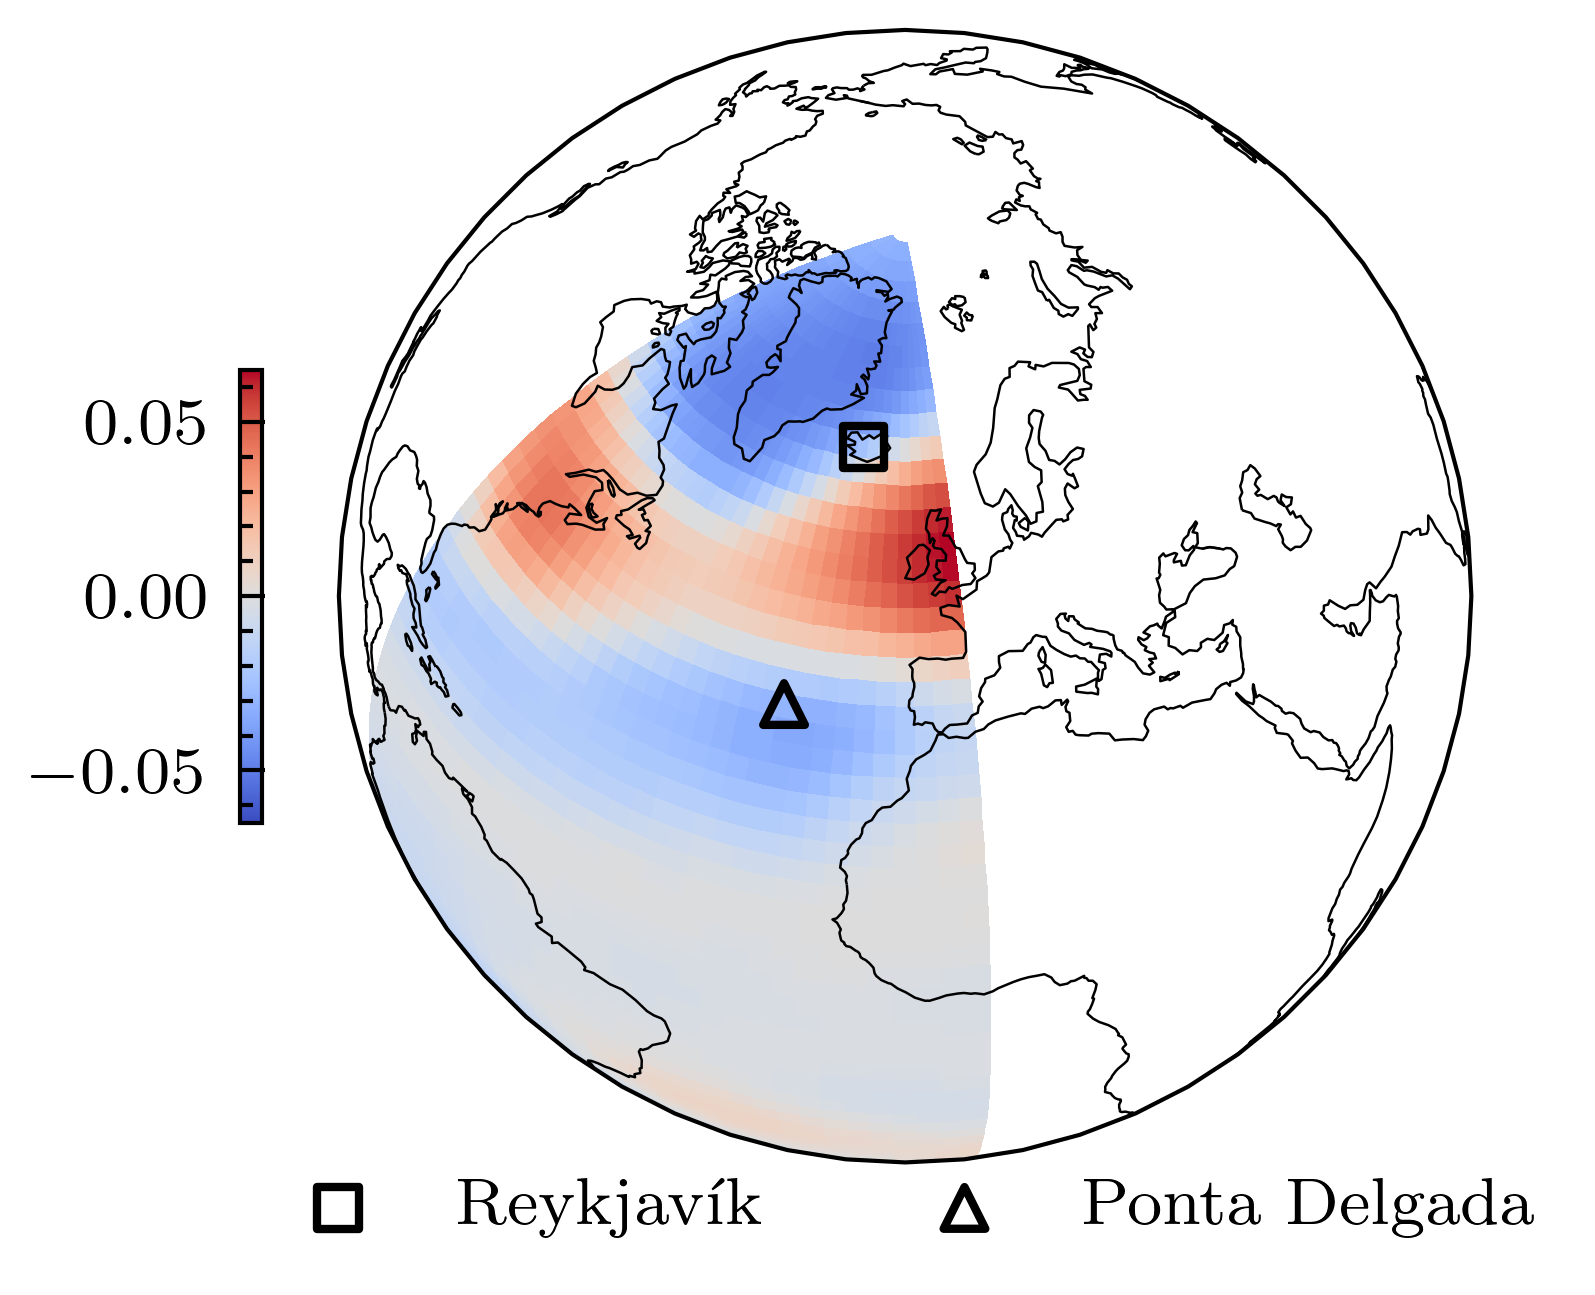

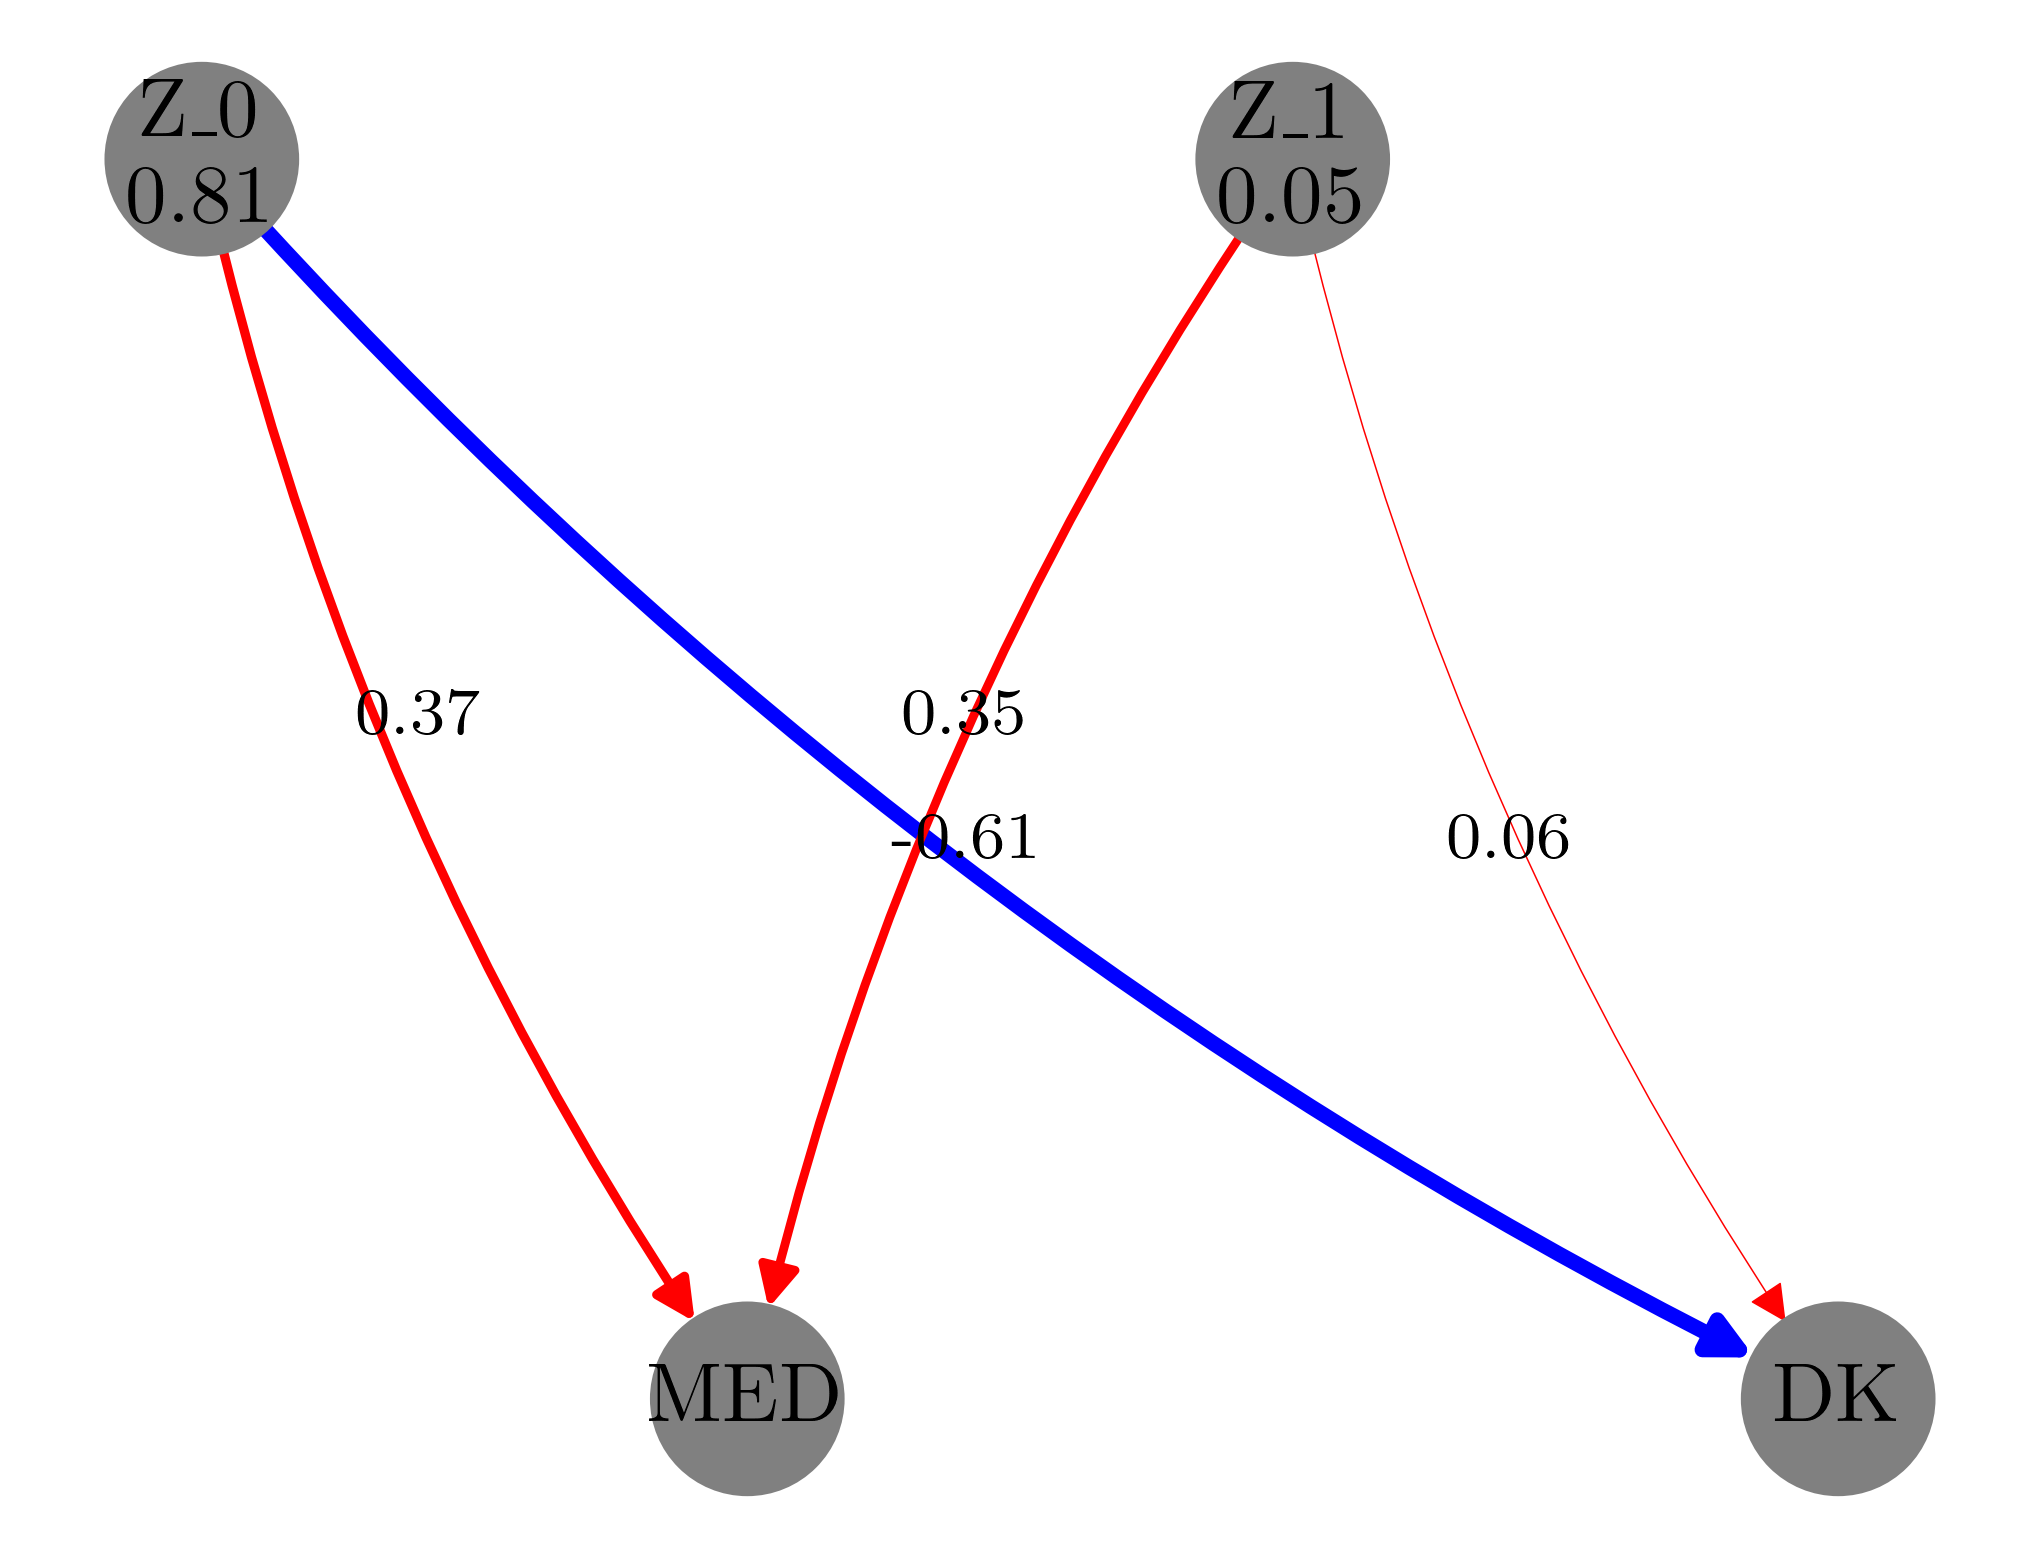

In [25]:
method = 'PLS'
plot_corr(results, Z, method=method, time=med['time'].to_numpy())
plot_weights(results, cp=0, method=method, latitudes = pressure['lat'], longitudes = pressure['lon'], original_shape=original_shape)
confounders = results[method]['confounder']
coef_MED = LinearRegression().fit(np.hstack((confounders, DK[:,None])), MED).coef_.round(2)
coef_DK = LinearRegression().fit(np.hstack((confounders, MED[:,None])), DK).coef_.round(2)
plot_graph(results, coef_MED, coef_DK, method, NAO=Z)

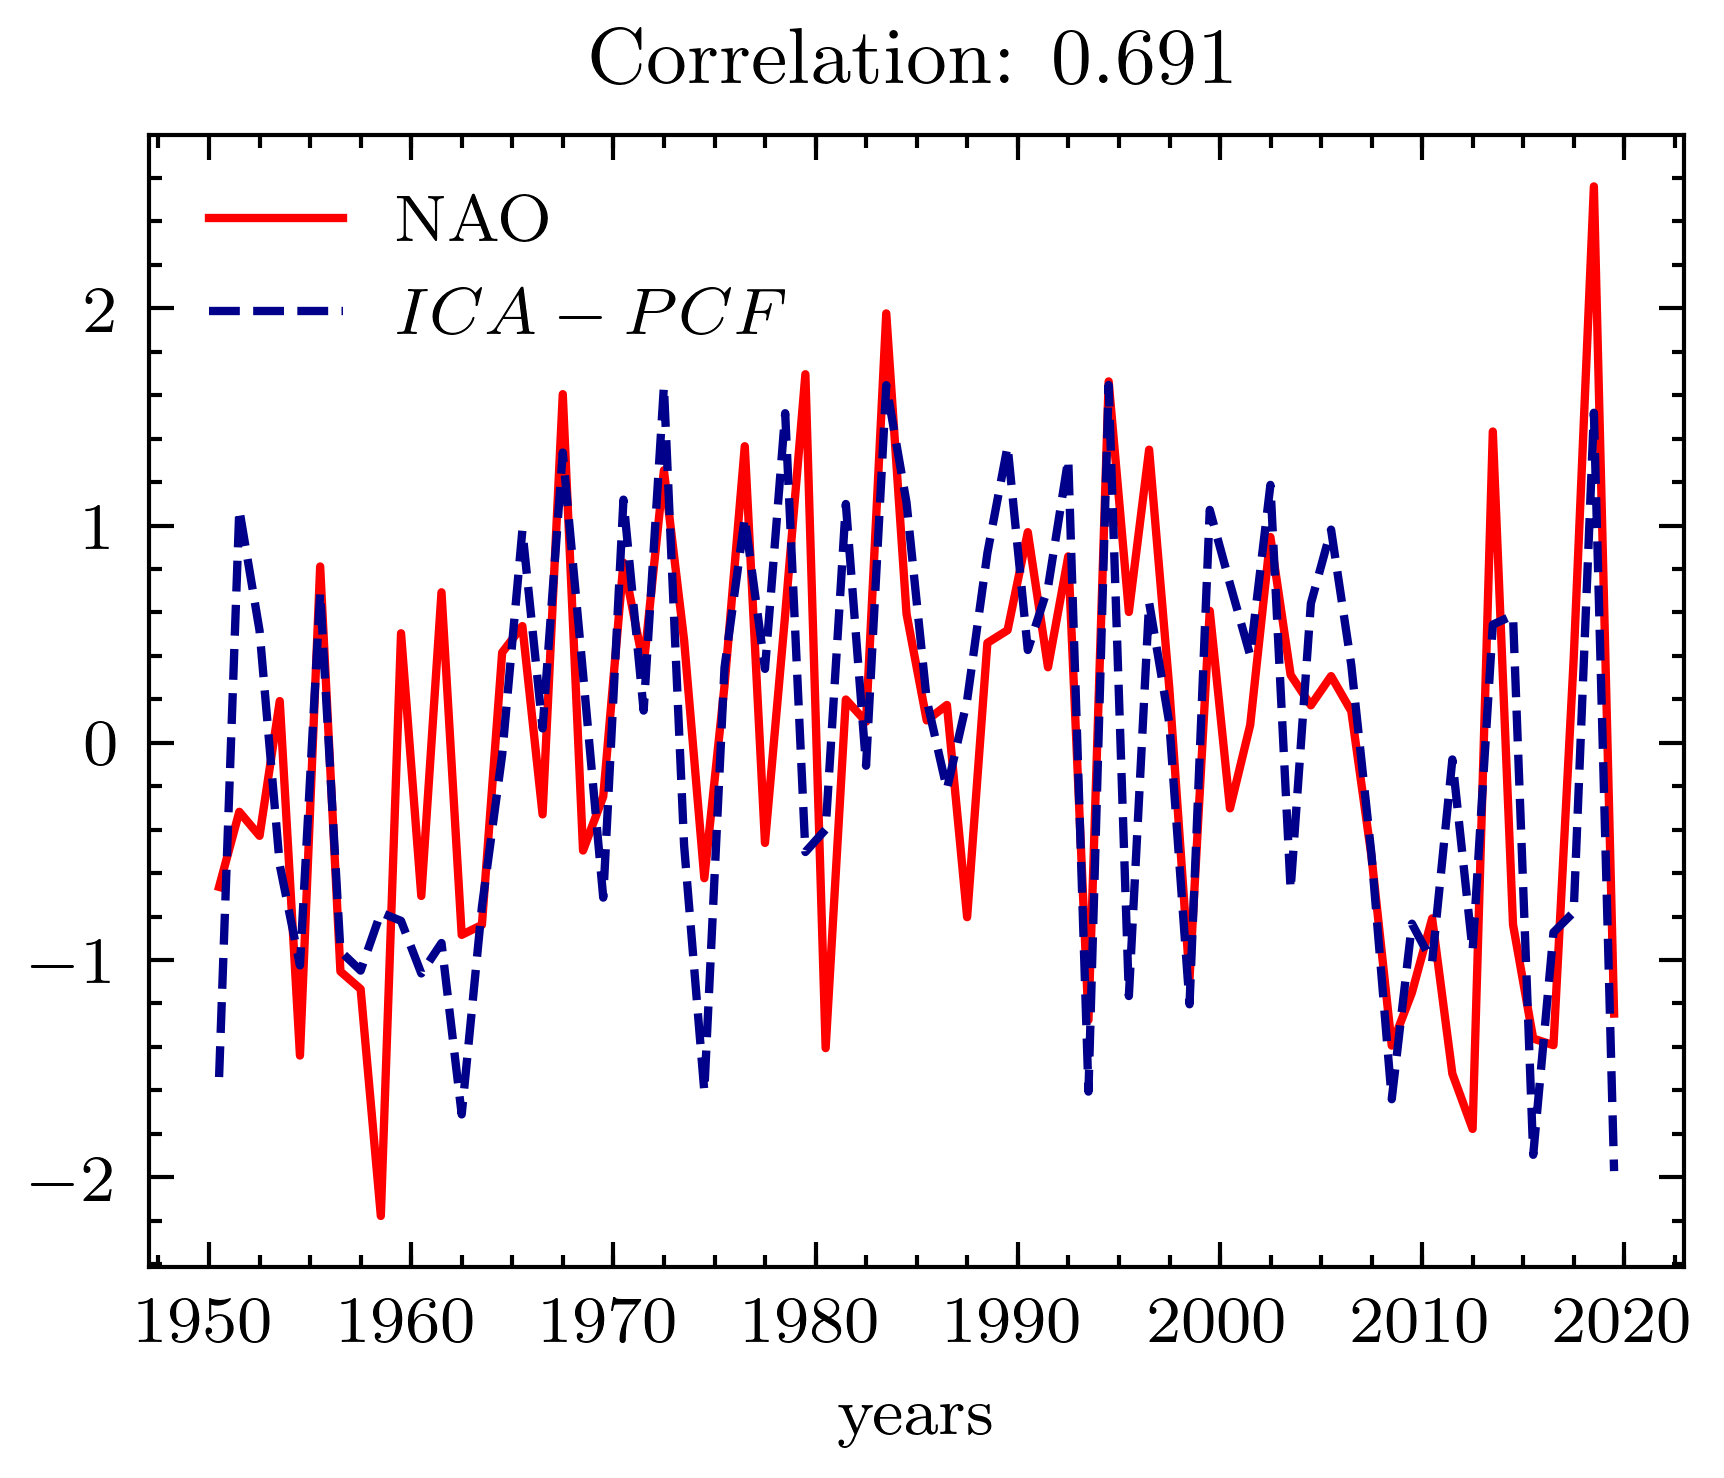

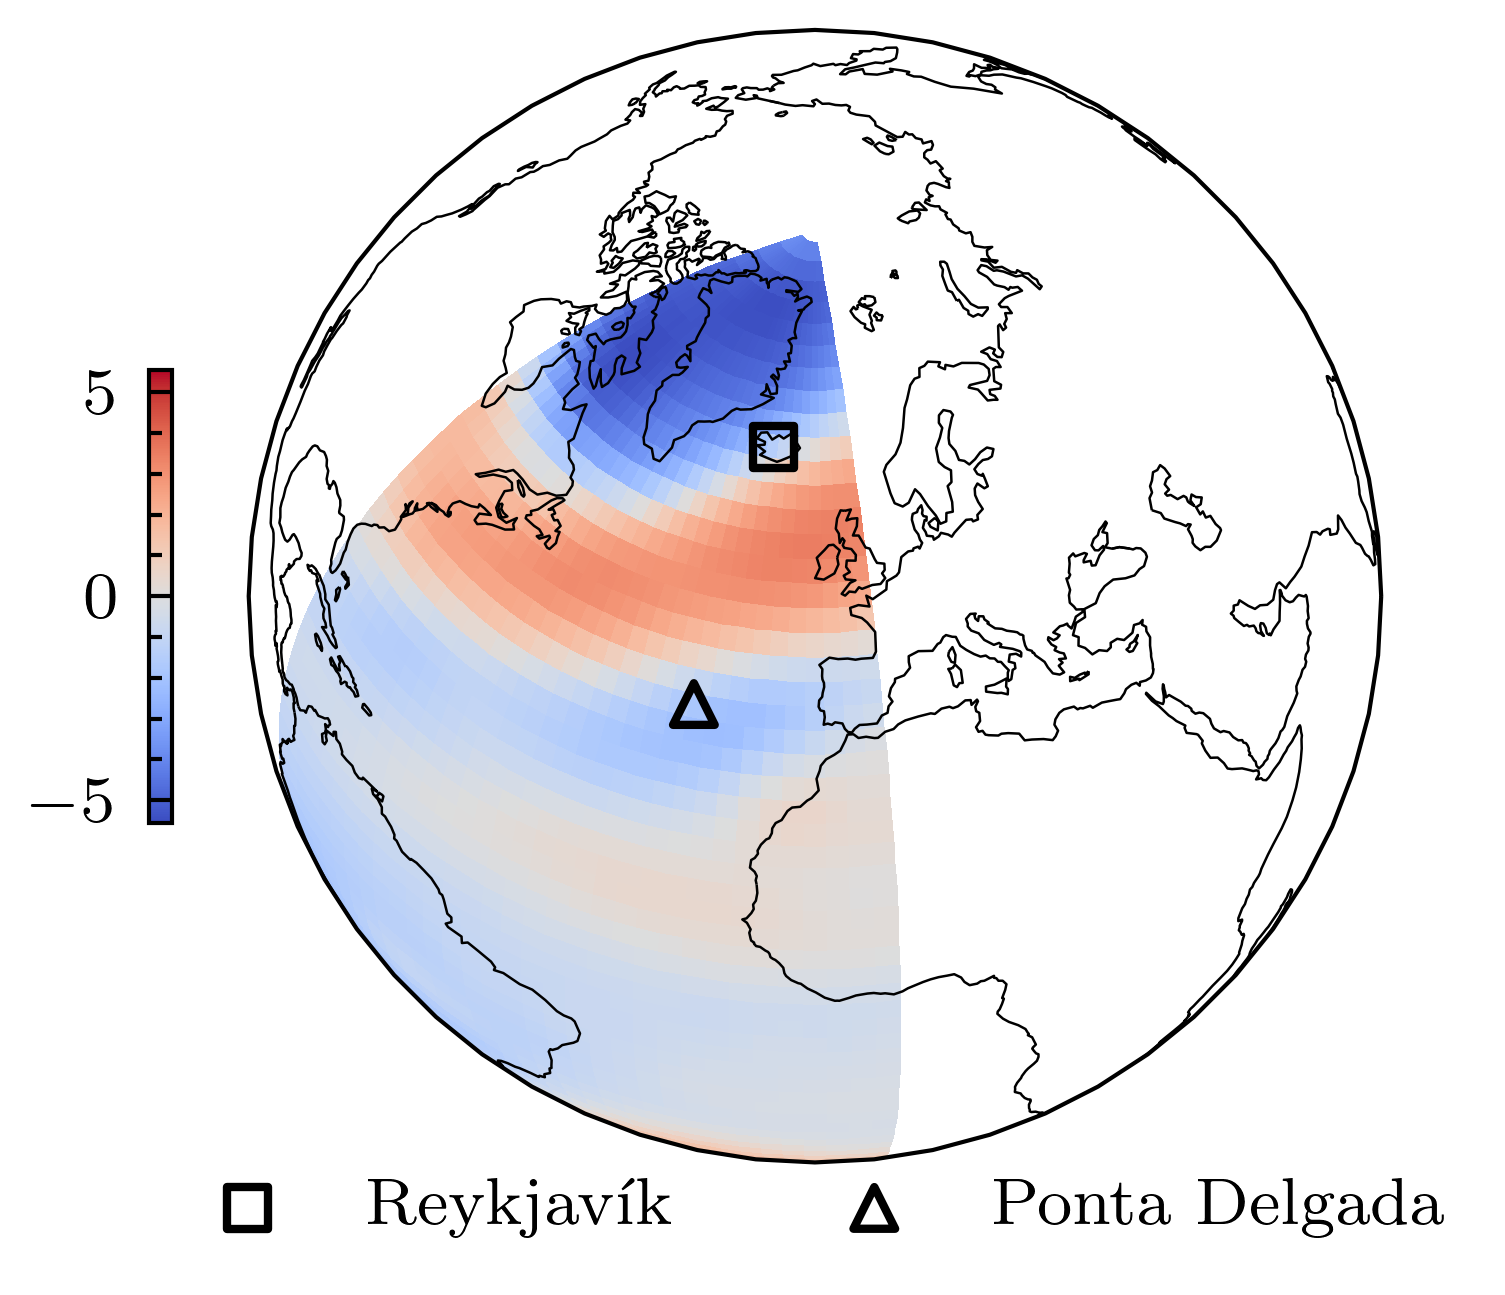

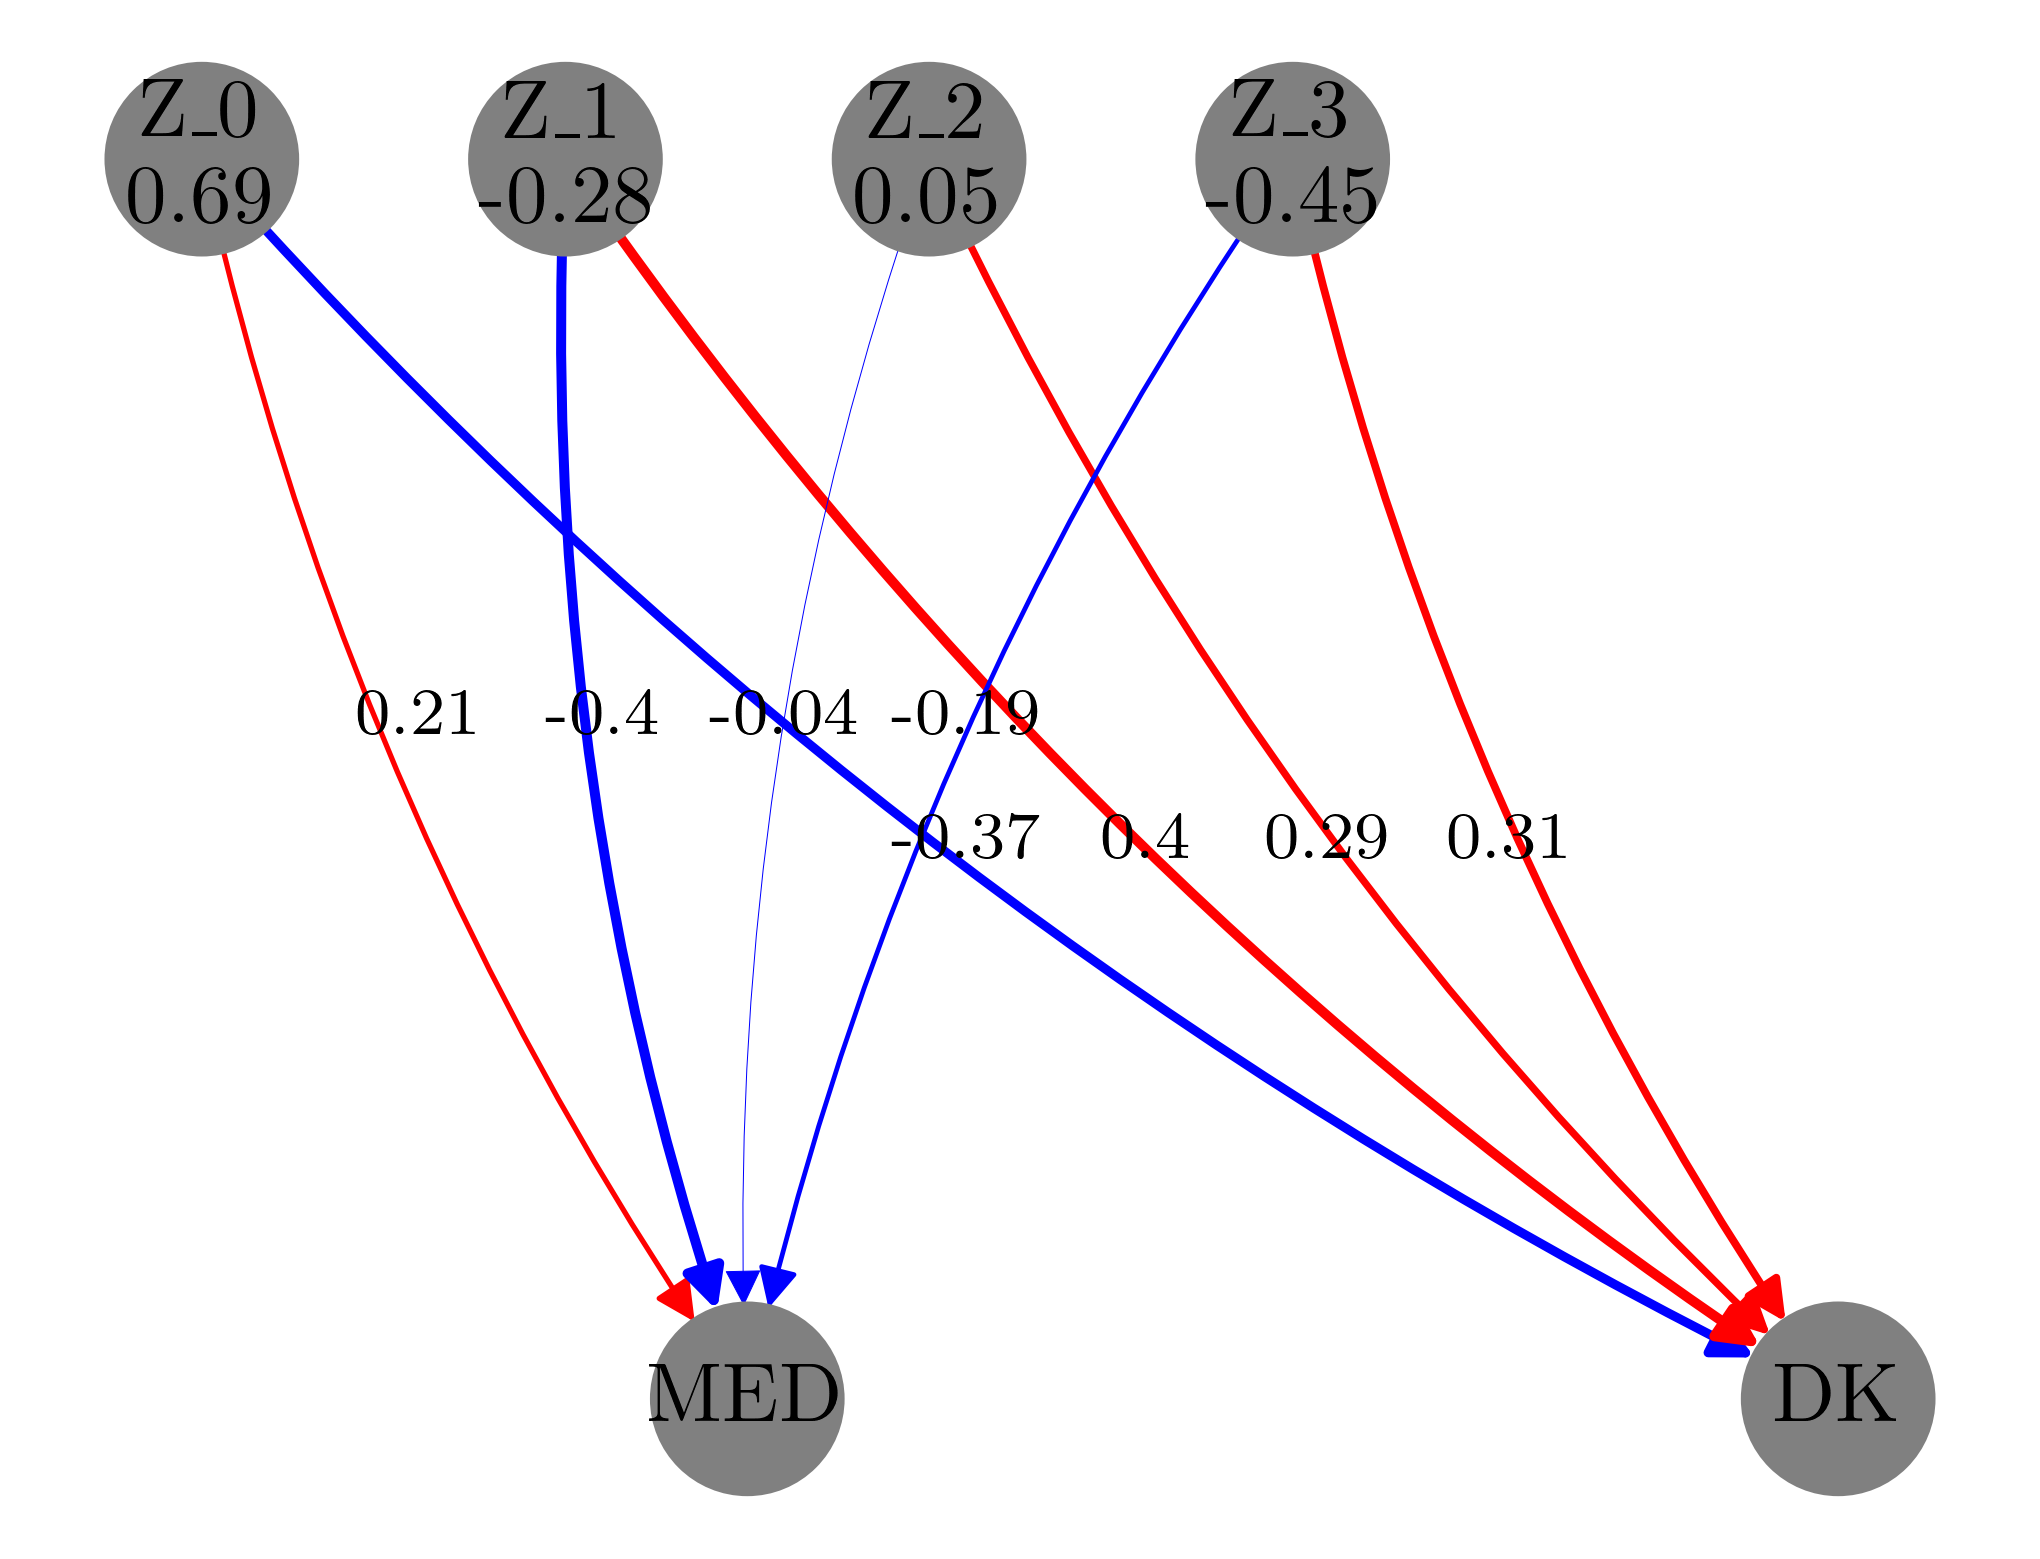

In [26]:
method = 'ICA'
plot_corr(results, Z, method=method, time=med['time'].to_numpy())
plot_weights(results, cp=0, method=method, latitudes = pressure['lat'], longitudes = pressure['lon'], original_shape=original_shape)
confounders = results[method]['confounder']
coef_MED = LinearRegression().fit(np.hstack((confounders, DK[:,None])), MED).coef_.round(2)
coef_DK = LinearRegression().fit(np.hstack((confounders, MED[:,None])), DK).coef_.round(2)
plot_graph(results, coef_MED, coef_DK, method, NAO=Z)